# A Study on Factors That are Related to Business Star Ratings

### Introduction

Yelp is a popular online platform that allows users to discover local businesses and post reviews about the ones they have already visited. By providing users with information such as the business's rating, location, attributes, and other user reviews, Yelp makes it easier for users to find a business that fits their specific preferences. 

The following notebook uses the business data file from Yelp's Open Dataset (version 7):       
https://www.kaggle.com/yelp-dataset/yelp-dataset/version/7

The documentation for the data files can be found here: https://www.yelp.com/dataset/documentation/main

The **business data file** contains **188593 records of businesses** on Yelp and information including the business's id, name, neighborhood, address, city, state, postal code, latitude, longitude, stars, review count, open status, attributes, categories and hours. 

The **reviews data file** contains **5996996 records of reviews** written on Yelp and information including the review_id, user_id, business's id, stars, date, text, and upvotes on whether the review was marked as **useful, funny, or cool.**

For the first part of this project, we will be mainly looking at the relationship between seven predictive covariates (X) and one outcome (Y). The seven X variables are:

1. The percentage of useful reviews per State per Year 
2. The percentage of funny reviews per State per Year 
3. The percentage of cool reviews per State per Year 
4. The number of open days for a business
5. The number of additional positive attributes 
6. The number of categories the business belongs to
7. The Median Household Income Per State Per Year

The **Percentage of useful, funny, or cool reviews** will be calculated by finding the number of each kind of review then dividing it by the total number of reviews regardless of kind. 
Any review that has one or more upvotes for a category will be recorded as a review in that specified category. For instance, a review with 5 useful upvotes and another with 3 useful upvotes will both be counted as a useful review. The magnitude of the upvotes will not matter. These variables will be used to understand the relationship between online presence of businesses and their star rating. 

The **number of open days for a business** are determined by the **days of the week**, where the maximum number of open days is seven, and the minimum number of open days is one. This variable is to understand the relation of actual business attributes on star rating. 

The **number of additional positive attributes** looks at information found in the business's attributes on their Yelp Profile. Attributes are listed in a dictionary format, where the key is the attribute name and the value is the attribute status. For example, a business could have two attribues, Bike Parking and Accepts Credit Cards. If the status of Bike Parking was False and Accepts Credit Cards was True, then the additional positive attributes will be equal to one, as our algorithm **will only count attributes with a status equal to True**. Through this method, we will be able to determine the additional positive attributes of a business based on their Yelp Profile. 

The **number of categories** a business belongs to can be found in the the business categories column. The two variables, number of additional positive attributes and the number of categories, represent characteristics a consumer would percieve based on a business' online profile, which in this case, is their Yelp profile. We will examine these variables to determine if there is a relation between the perceieve attributes of a business and its star rating on Yelp. 

The **Median Household Income** data will be webscrapped from an online source. The data will have the median household income for all US states from 2010 to 2014.

Finally, our outcome variable (Y), is the **business's star rating**. This value is the **average rating from all of the business's user reviews**. The maximum rating is five stars and the minimum rating found in the data set is one star.

The following paper will explore the yelp dataset to determine whether these seven factors are related to a business star rating on Yelp.

# Project One

### Import and Read Yelp Business Data File

In [1]:
import os
import numpy as np
import pandas as pd

os.getcwd()

import json

## Get Data From Yelp's Business Json file

In [2]:
# First we will open the json file and convert it into a dataframe
frames = []
with open('/Users/work/Desktop/ECO225Project/Data/yelp_academic_dataset_business.json') as json_file:
    for line in json_file:
        data = json.loads(line)
        frames.append(data)

df = pd.DataFrame.from_dict(frames)
df = df.set_index(["business_id"])

## Clean the Business DataFrame

##### Replace blanks with np.nan 

In [3]:
# for the city column, we will search and replace blanks 
# with np.nan so that we can drop the rows with blank values

df['city'] = df['city'].replace('', np.nan)

##### Drop null values

In [4]:
# Now we will drop all the columns that have blanks 
df = df.dropna()

##### Clean the Strings of the City and State

In [5]:
# The following function will clean a given string
# This function will be used to clean all the records of the city names found 
# in the city column of the dataframe.

def clean(string, df1):
    
    # convert the string to lower case, with first letter capitalized
    # e.g. 'TORONTO' -> 'Toronto'
    string = string.lower().title()
    
    # check to see if there are brackets in string, if there are brackets,
    # then it checks if the word in brackets is already in the Dataframe's 
    # unique values, if true, then it will replace the whole string with the
    # value in the brackets unless the value is 
    # Quebec as there is Québec province and city
    # but we will assume the brackets refer to the province
    # e.x. 'North York (Toronto)' -> 'Toronto'

    if '(' in string or ')' in string:
        start = string.find('(')
        end = string.find(')')
        word = string[start + 1:end]
        if word not in df1['city'].unique() or word == 'Québec':
            string = string[:start] + string[end + 1:]
        else:
            string = word
    
    # find if there are commas and remove any trailing letters 
    # e.x. 'Toronto, ON' --> 'Toronto'
    if ',' in string:
        start = string.find(',')
        string = string[:start]
    
    # if there are more words in the string then we will clean those words too 
    # e.g. '1500 N E Toronto' -> 'Toronto'
    if ' ' in string:
        words = string.split(' ')

        copy = words.copy()
        for word in copy:
            if len(word) <= 2 or word.isdigit():
                words.remove(word)
        
        # re-build the string with the cleaned text
        num = len(words)
        result = words[0]
        for i in range(1, num):
            result = result + ' ' + words[i]
            string = result
    
    # replace some common abbreviations
    if 'Hts' in string:
        string = string.replace('Hts', 'Heights')
    if 'Twp' in string:
        string = string.replace('Twp', 'Heights')
        
    # remove any extra whitespace at beginning of string
    string = string.strip()
    
    return string

In [6]:
# The following function will clean the strings representation 
# of states found in df['state']
def clean_abbrev(string):
    
    # replaces the string if the string is less than 2 characters 
    # long or is a digit
    # e.g. 'ON' -> 'ON', 'C' -> np.nan, '01' -> np.nan
    if len(string) != 2 or string.isdigit():
        string = np.nan
    return string

In [7]:
# Take all the city values then clean and append into a 
# new list of cleaned values 
# Take all state values and clean and append to new list 

cities = list(df['city'].values)
states = list(df['state'].values)

cleaned_city = []
cleaned_state = []

for city in cities:
    cleaned_city.append(clean(city, df))

for state in states:
    cleaned_state.append(clean_abbrev(state))

In [8]:
# Drop old city and state columns from dataframe and add the 
# new ones onto the dataframe
cleaned_df = df.copy()
cleaned_df = cleaned_df.drop(['city', 'state'], axis=1)

cleaned_df['city'] = cleaned_city
cleaned_df['state'] = cleaned_state

In [9]:
# Drop any nans from when we cleaned the states
cleaned_df = cleaned_df.dropna().reset_index()

In [10]:
cleaned_df

business_id                             name  \
0       Apn5Q_b6Nz61Tq4XzPdf9A             Minhas Micro Brewery   
1       AjEbIBw6ZFfln7ePHha9PA              CK'S BBQ & Catering   
2       O8S5hYJ1SMc8fA4QBtVujA                    La Bastringue   
3       8USyCYqpScwiNEb58Bt6CA                    Action Engine   
4       45bWSZtniwPRiqlivpS8Og       The Coffee Bean & Tea Leaf   
...                        ...                              ...   
127356  Y_7sZoSLTJ-2mNZS8JS5Pg               Toronto Yoga Mamas   
127357  sMQAZ3DkfrURFoJAyOhjEw                     Ross Massage   
127358  KleCXFYOmdACcQUvf6_XEg              Walmart Supercenter   
127359  3_fIsSxN2RBovQ_6EFtLzA  Residence Inn Charlotte Concord   
127360  NkOvIueadjFUxeCyq_uQEw     Tito Jimy Salon and Boutique   

                     neighborhood                          address  \
0                                                1314 44 Avenue NE   
1                                                                    
2       Rosemont-La Petite-Patrie              1335 rue Beaubien E   
3                                              2005 Alyth Place SE   
4                                  20235 N Cave Creek Rd, Ste 1115   
...                           ...                              ...   
127356                Leslieville     1402 Queen Street E, Suite D   
127357                                   8000 McKnight Rd, Ste 570   
127358                                             5825 Thunder Rd   
127359                                     7601 Scott Padgett Pkwy   
127360                   Eastside          3900 Paradise Rd, Ste R   

       postal_code   latitude   longitude  stars  review_count  is_open  \
0          T2E 6L6  51.091813 -114.031675    4.0            24        1   
1            89002  35.960734 -114.939821    4.5             3        0   
2          H2G 1K7  45.540503  -73.599300    4.0             5        0   
3          T2H 0N5  51.035591 -114.027366    2.0             4        1   
4            85024  33.671375 -112.030017    4.0            63        1   
...            ...        ...         ...    ...           ...      ...   
127356     M4L 1C9  43.664756  -79.324295    5.0            14        1   
127357       15237  40.551152  -80.021213    2.5             9        0   
127358       28027  35.378669  -80.724733    3.0            26        1   
127359       28027  35.364366  -80.703454    4.0            19        1   
127360       89169  36.118697 -115.154269    4.0             8        1   

                                               attributes  \
0       {'BikeParking': 'False', 'BusinessAcceptsCredi...   
1       {'Alcohol': 'none', 'BikeParking': 'False', 'B...   
2       {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
3                  {'BusinessAcceptsCreditCards': 'True'}   
4       {'BikeParking': 'True', 'BusinessAcceptsCredit...   
...                                                   ...   
127356  {'BikeParking': 'True', 'BusinessParking': '{'...   
127357  {'AcceptsInsurance': 'False', 'BusinessAccepts...   
127358  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
127359  {'BusinessAcceptsCreditCards': 'True', 'DogsAl...   
127360  {'BikeParking': 'True', 'BusinessAcceptsCredit...   

                                               categories  \
0       Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1       Chicken Wings, Burgers, Caterers, Street Vendo...   
2       Breakfast & Brunch, Restaurants, French, Sandw...   
3       Home & Garden, Nurseries & Gardening, Shopping...   
4                                      Coffee & Tea, Food   
...                                                   ...   
127356  Massage, Health & Medical, Yoga, Doulas, Activ...   
127357        Skin Care, Beauty & Spas, Day Spas, Massage   
127358  Mobile Phones, Shopping, Department Stores, Fo...   
127359  Event Planning & Services, Hotels & Travel, Ho...   
127360  Makeup Artists, Men's Clothing, Swimwear, Shop...   

      

## Get Data From Yelp's Reviews Json File

In [11]:
# We will repeat this step for the Business Reviews Json File 
r_frames = []
with open('/Users/work/Desktop/ECO225Project/Data/yelp_academic_dataset_review.json') as json_file:
    for line in json_file:
        data = json.loads(line)
        r_frames.append(data)

review_df = pd.DataFrame.from_dict(r_frames)

#### Create Dummy Variables for useful, funny, and cool reviews

In [12]:
# We will now create a dummy variable to indicate whether a review is useful, funny, or cool
# For example, any review with a useful rating greater than 1 will count as a useful review
# Which will result in a useful dummy value equal to 1

review_df['useful dummy'] = (review_df['useful'] >= 1).astype(int)
review_df['funny dummy'] = (review_df['funny'] >= 1).astype(int)
review_df['cool dummy'] = (review_df['cool'] >= 1).astype(int)

In [13]:
review_df

review_id                 user_id  \
0        x7mDIiDB3jEiPGPHOmDzyw  msQe1u7Z_XuqjGoqhB0J5g   
1        dDl8zu1vWPdKGihJrwQbpw  msQe1u7Z_XuqjGoqhB0J5g   
2        LZp4UX5zK3e-c5ZGSeo3kA  msQe1u7Z_XuqjGoqhB0J5g   
3        Er4NBWCmCD4nM8_p1GRdow  msQe1u7Z_XuqjGoqhB0J5g   
4        jsDu6QEJHbwP2Blom1PLCA  msQe1u7Z_XuqjGoqhB0J5g   
...                         ...                     ...   
5996991  ulyWlcLQ9CYleyh8lYOKVw  LOUrYMvz-R0YPr0E80gk1A   
5996992  yPkClnqE7O7IibSuuswwrw  FaAITTapZkngBDJus4niJQ   
5996993  ixnpFW4VZ3RFiOMSacg2ng  FaAITTapZkngBDJus4niJQ   
5996994  UeLaZUk5TnqwUJ_uS6u-og  NOrAsGtOH9BwPpcRWgo4-g   
5996995  misKlgKbNQXt-Zzd8PEdCw  NOrAsGtOH9BwPpcRWgo4-g   

                    business_id  stars        date  \
0        iCQpiavjjPzJ5_3gPD5Ebg      2  2011-02-25   
1        pomGBqfbxcqPv14c3XH-ZQ      5  2012-11-13   
2        jtQARsP6P-LbkyjbO1qNGg      1  2014-10-23   
3        elqbBhBfElMNSrjFqW3now      2  2011-02-25   
4        Ums3gaP2qM3W1XcA5r6SsQ      5  2014-09-05   
...                         ...    ...         ...   
5996991  abIF7pw1Hyu-eVW3LwNhyg      1  2016-02-29   
5996992  fbLYRHIZAt3q839whhaBUg      1  2017-07-06   
5996993  b_8jCti0vuouJ_fjZpdmZw      4  2018-04-14   
5996994  wY3dlpLa0BHfDENYAPYuZA      1  2018-04-07   
5996995  6E4i0NHTRAgpwbbRwZhlnw      1  2018-06-07   

                                                      text  useful  funny  \
0        The pizza was okay. Not the best I've had. I p...       0      0   
1        I love this place! My fiance And I go here atl...       0      0   
2        Terrible. Dry corn bread. Rib tips were all fa...       3      1   
3        Back in 2005-2007 this place was my FAVORITE t...       2      0   
4        Delicious healthy food. The steak is amazing. ...       0      0   
...                                                    ...     ...    ...   
5996991  I must admit i have had very bad experience he...       0      0   
5996992  Worst service experience in awhile. I usually ...       0      1   
5996993  Loved the location, the patio, the service, an...       0      0   
5996994  I absolutely hate this place. I would give it ...       0      0   
5996995  The first and the last time I will go there. M...       0      0   

         cool  useful dummy  funny dummy  cool dummy  
0           0             0            0           0  
1           0             0            0           0  
2           1             1            1           1  
3           0             1            0           0  
4           0             0            0           0  
...       ...           ...          ...         ...  
5996991     1             0            0           1  
5996992     0             0            1           0  
5996993     1             0            0           1  
5996994     0             0            0           0  
5996995     0             0            0           0  

[5996996 rows x 12 columns]

In [14]:
# take the dates and make a list 
dates = list(review_df['date'].values)

In [15]:
# find the year for each review in the review_df
year = []
for date in dates:
    y = int(date[:4])
    year.append(y)

In [16]:
# create a new column for the year of each review 
review_df['year'] = year

In [17]:
# create a new column to count the number of reviews for a business over time 
review_df['r_count'] = 1

### Create a Dataframe Grouped by Business ID and Year

In [18]:
# make a new dataframe for our longitudinal data 
stars_data = review_df[['business_id', 'stars', 'year']].copy()

In [19]:
# create a new groupby business 
# and year to find the average star 
# rating of a business in a specific year 

gbID_year = stars_data.groupby(['business_id', 'year']).mean().reset_index()

In [20]:
# find the number of each kind of review 
# and count the total number of reviews 
# for a business over time

sum_reviews = review_df[['business_id', 'year', 
                         'useful dummy', 'funny dummy', 
                         'cool dummy', 'r_count']].copy()

review_kind = sum_reviews.groupby(['business_id', 'year']).sum().reset_index()

In [21]:
# merge the columsn onto the long_df and rename the columns

gbID_year = pd.merge(gbID_year, review_kind, how='left', 
                   on=['business_id', 
                       'year']).rename(columns={'useful dummy': 'Number of Useful Reviews', 
                                                'funny dummy': 'Number of Funny Reviews', 
                                                'cool dummy': 'Number of Cool Reviews', 
                                                'r_count': 'Number of Reviews', 
                                                'stars': 'Average Star Rating'})

In [22]:
gbID_year = pd.merge(gbID_year, cleaned_df, how='left', on='business_id')

In [23]:
# drop the null values due to some rows that were dropped from the 
# before in the cleaned_df during the data cleaning process

gbID_year = gbID_year.dropna()

In [24]:
gbID_year

business_id  year  Average Star Rating  \
0       --1UhMGODdWsrMastO9DZw  2016             3.800000   
1       --1UhMGODdWsrMastO9DZw  2017             4.600000   
2       --1UhMGODdWsrMastO9DZw  2018             3.250000   
3       --6MefnULPED_I942VcFNA  2008             5.000000   
4       --6MefnULPED_I942VcFNA  2010             2.333333   
...                        ...   ...                  ...   
846121  zzwicjPC9g246MK2M1ZFBA  2017             2.750000   
846122  zzwicjPC9g246MK2M1ZFBA  2018             3.272727   
846123  zzzaIBwimxVej4tY6qFOUQ  2012             3.500000   
846124  zzzaIBwimxVej4tY6qFOUQ  2013             3.380952   
846125  zzzaIBwimxVej4tY6qFOUQ  2014             3.545455   

        Number of Useful Reviews  Number of Funny Reviews  \
0                              4                        0   
1                              1                        1   
2                              0                        0   
3                              1                        1   
4                              3                        3   
...                          ...                      ...   
846121                         1                        1   
846122                         1                        3   
846123                         6                        3   
846124                        13                        4   
846125                         7                        1   

        Number of Cool Reviews  Number of Reviews  \
0                            7                 10   
1                            4                 10   
2                            0                  4   
3                            1                  1   
4                            3                  3   
...                        ...                ...   
846121                       0                  8   
846122                       1                 11   
846123                       2                  6   
846124                       3                 21   
846125                       1                 11   

                                 name neighborhood  \
0                    The Spicy Amigos                
1                    The Spicy Amigos                
2                    The Spicy Amigos                
3       John's Chinese BBQ Restaurant                
4       John's Chinese BBQ Restaurant                
...                               ...          ...   
846121                        Sizzler                
846122                        Sizzler                
846123                      Guthrie's    Northwest   
846124                      Guthrie's    Northwest   
846125                      Guthrie's    Northwest   

                                           address  ...   latitude  \
0                                  821 4 Avenue SW  ...  51.049673   
1                                  821 4 Avenue SW  ...  51.049673   
2                                  821 4 Avenue SW  ...  51.049673   
3       328 Highway 7 E, Chalmers Gate 11, Unit 10  ...  43.840905   
4       328 Highway 7 E, Chalmers Gate 11, Unit 10  ...  43.840905   
...                                            ...  ...        ...   
846121                      1050 S Country Club Dr  ...  33.395974   
846122                      1050 S Country Club Dr  ...  33.395974   
846123                         6728 W Cheyenne Ave  ...  36.218424   
846124                         6728 W Cheyenne Ave  ...  36.218424   
846125                         6728 W Cheyenne Ave  ...  36.218424   

         longitude  stars  review_count  is_open  \
0      -114.079977    4.0          24.0      1.0   
1      -114.079977    4.0          24.0      1.0   
2      -114.079977    4.0          24.0      1.0   
3       -79.399604    3.0          39.0      1.0   
4       -79.399604    3.0          39.0      1.0   
...            ...    ...           ...      ...   
846121 -111.840651    3.0          63.0      1.0   
846122 -11

### Create a DataFrame Grouped by Business ID only

In [25]:
# copy the business_id and stars column from review_df
total_reviews = review_df[['business_id', 'stars']].copy()

In [26]:
# create a new groupby business 
# and year to find the average star 
# rating of a business in a specific year 

total_reviews = total_reviews.groupby(['business_id']).mean().reset_index()

In [27]:
# find the number of each kind of review 
# and count the total number of reviews 
# for a business

sum_reviews2 = review_df[['business_id', 'useful dummy', 'funny dummy', 
                         'cool dummy', 'r_count']].copy()

sum_reviews2 = sum_reviews2.groupby(['business_id']).sum().reset_index()

In [28]:
# merge the columns onto total_reviews and rename the columns

gbID = pd.merge(total_reviews, 
                         sum_reviews2, 
                         how='left', 
                         on=['business_id']).rename(columns={'useful dummy': 
                                                             'Number of Useful Reviews', 
                                                'funny dummy': 'Number of Funny Reviews', 
                                                'cool dummy': 'Number of Cool Reviews', 
                                                'r_count': 'Number of Reviews', 
                                                'stars': 'Average Star Rating'})

In [29]:
# merge clean_df onto gbID
gbID = pd.merge(gbID, cleaned_df, how='left', on='business_id')

In [30]:
# drop any null values due to differences in rows 
# as cleaned_df dropped some rows with null values 
# during the data cleaning process

gbID = gbID.dropna()

In [31]:
gbID

business_id  Average Star Rating  Number of Useful Reviews  \
0       --1UhMGODdWsrMastO9DZw             4.041667                         5   
1       --6MefnULPED_I942VcFNA             3.128205                        19   
2       --7zmmkVg-IMGaXbuVd0SQ             3.870370                        31   
3       --8LPVSo5i0Oo61X01sV9A             3.500000                         2   
5       --9e1ONYQuAa-CB_Rrw7Tw             4.102846                       584   
...                        ...                  ...                       ...   
188588  zzvlwkcNR1CCqOPXwuvz2A             3.200000                         1   
188589  zzwaS0xn1MVEPEf0hNLjew             3.426471                        30   
188590  zzwhN7x37nyjP0ZM8oiHmw             4.250000                        24   
188591  zzwicjPC9g246MK2M1ZFBA             2.920635                        34   
188592  zzzaIBwimxVej4tY6qFOUQ             3.447368                        26   

        Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                             1                      11                 24   
1                            13                      13                 39   
2                            20                      27                 54   
3                             0                       0                  4   
5                           326                     376               1546   
...                         ...                     ...                ...   
188588                        0                       0                  5   
188589                       22                      22                 68   
188590                        5                       9                 44   
188591                       24                      20                 63   
188592                        8                       6                 38   

                                     name   neighborhood  \
0                        The Spicy Amigos                  
1           John's Chinese BBQ Restaurant                  
2                          Primal Brewery                  
3       Valley Bone and Joint Specialists                  
5                    Delmonico Steakhouse      The Strip   
...                                   ...            ...   
188588                          7 Dim Sum  Downtown Core   
188589                 Dilly Dally Lounge                  
188590                   Carmody's Grille                  
188591                            Sizzler                  
188592                          Guthrie's      Northwest   

                                           address postal_code   latitude  \
0                                  821 4 Avenue SW     T2P 0K5  51.049673   
1       328 Highway 7 E, Chalmers Gate 11, Unit 10     L4B 3P7  43.840905   
2                         16432 Old Statesville Rd       28078  35.437086   
3                      3941 E Baseline Rd, Ste 102       85234  33.378589   
5                            3355 Las Vegas Blvd S       89109  36.123183   
...                                            ...         ...        ...   
188588                           45 Baldwin Street     M5T 1L1  43.655822   
188589                     3639 E Indian School Rd       85018  33.495156   
188590                              4905 Grand Ave       15225  40.510026   
188591                      1050 S Country Club Dr       85210  33.395974   
188592                         6728 W Cheyenne Ave       89108  36.218424   

         longitude  stars  review_count  is_open  \
0      -114.079977    4.0          24.0      1.0   
1       -79.399604    3.0          39.0      1.0   
2       -80.843688    4.0          54.0      1.0   
3      -111.748145    3.5           4.0      1.0   
5      -115.169190    4.0        1546.0      1.0   
...            ...    ...           ...      ...   
188588  -79.393727    3.0           5.0      1.0   
188589 -112.003349    3.5          68.0      1.

### Add in New Calculated Columns for the X Variables for each Business

In [32]:
# Create a new column for days_open
hours_list = list(gbID['hours'].values)

# Get days open values
days_open = []
for record in hours_list:
    days_open.append(len(record))
    
# Add column to cleaned dataframe
gbID['days_open'] = days_open

In [33]:
# We will create a new column for number of True attributes 
attributes_list = list(gbID['attributes'].values)
true_attributes = []

for record in attributes_list:
    count = 0
    for key in record:
        try:
            if type(eval(record[key])) == dict:
                converted = eval(record[key])
                for subkey in converted:
                    if converted[subkey] == True:
                        count += 1
        except:
            continue
        
        if record[key] == 'True':
            count += 1
    true_attributes.append(count)

gbID['num_true_attributes'] = true_attributes

In [34]:
# Create a new column for number of categories
categories_list = list(gbID['categories'].values)
num_categories = []

for record in categories_list:
    num_categories.append(len(list(record.split(','))))

gbID['num_categories'] = num_categories

In [35]:
gbID

business_id  Average Star Rating  Number of Useful Reviews  \
0       --1UhMGODdWsrMastO9DZw             4.041667                         5   
1       --6MefnULPED_I942VcFNA             3.128205                        19   
2       --7zmmkVg-IMGaXbuVd0SQ             3.870370                        31   
3       --8LPVSo5i0Oo61X01sV9A             3.500000                         2   
5       --9e1ONYQuAa-CB_Rrw7Tw             4.102846                       584   
...                        ...                  ...                       ...   
188588  zzvlwkcNR1CCqOPXwuvz2A             3.200000                         1   
188589  zzwaS0xn1MVEPEf0hNLjew             3.426471                        30   
188590  zzwhN7x37nyjP0ZM8oiHmw             4.250000                        24   
188591  zzwicjPC9g246MK2M1ZFBA             2.920635                        34   
188592  zzzaIBwimxVej4tY6qFOUQ             3.447368                        26   

        Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                             1                      11                 24   
1                            13                      13                 39   
2                            20                      27                 54   
3                             0                       0                  4   
5                           326                     376               1546   
...                         ...                     ...                ...   
188588                        0                       0                  5   
188589                       22                      22                 68   
188590                        5                       9                 44   
188591                       24                      20                 63   
188592                        8                       6                 38   

                                     name   neighborhood  \
0                        The Spicy Amigos                  
1           John's Chinese BBQ Restaurant                  
2                          Primal Brewery                  
3       Valley Bone and Joint Specialists                  
5                    Delmonico Steakhouse      The Strip   
...                                   ...            ...   
188588                          7 Dim Sum  Downtown Core   
188589                 Dilly Dally Lounge                  
188590                   Carmody's Grille                  
188591                            Sizzler                  
188592                          Guthrie's      Northwest   

                                           address postal_code  ...  \
0                                  821 4 Avenue SW     T2P 0K5  ...   
1       328 Highway 7 E, Chalmers Gate 11, Unit 10     L4B 3P7  ...   
2                         16432 Old Statesville Rd       28078  ...   
3                      3941 E Baseline Rd, Ste 102       85234  ...   
5                            3355 Las Vegas Blvd S       89109  ...   
...                                            ...         ...  ...   
188588                           45 Baldwin Street     M5T 1L1  ...   
188589                     3639 E Indian School Rd       85018  ...   
188590                              4905 Grand Ave       15225  ...   
188591                      1050 S Country Club Dr       85210  ...   
188592                         6728 W Cheyenne Ave       89108  ...   

        review_count  is_open  \
0               24.0      1.0   
1               39.0      1.0   
2               54.0      1.0   
3                4.0      1.0   
5             1546.0      1.0   
...              ...      ...   
188588           5.0      1.0   
188589          68.0      1.0   
188590          44.0      1.0   
188591          63.0      1.0   
188592          38.0      0.0   

                                               attributes  \
0       {'Alcohol': 'beer_and_wine', 'BusinessParking'...   
1       {'Alcoho

In [36]:
gbID['% Useful Reviews'] = gbID['Number of Useful Reviews']/gbID['Number of Reviews']
gbID['% Funny Reviews'] = gbID['Number of Funny Reviews']/gbID['Number of Reviews']
gbID['% Cool Reviews'] = gbID['Number of Cool Reviews']/gbID['Number of Reviews']

## Analysis

### Summary Statistics of Chosen X and Y Variables

##### Summary Statistics grouped by Business ID

In [37]:
# select the columns we want to look at 
columns = gbID.columns.tolist()
columns = columns[1:2] + columns[5:6] + columns[-3:] + columns[-6:-3]

# create a new dataframe with the selected columns 
variables_df = gbID[columns]
variables_df.describe()

Average Star Rating  Number of Reviews  % Useful Reviews  \
count        127361.000000      127361.000000     127361.000000   
mean              3.752516          41.809384          0.493827   
std               0.929831         124.215494          0.249406   
min               1.000000           1.000000          0.000000   
25%               3.166667           5.000000          0.333333   
50%               3.842105          12.000000          0.500000   
75%               4.500000          34.000000          0.666667   
max               5.000000        7968.000000          1.000000   

       % Funny Reviews  % Cool Reviews      days_open  num_true_attributes  \
count    127361.000000   127361.000000  127361.000000        127361.000000   
mean          0.190321        0.232223       6.426975             4.986079   
std           0.177996        0.198370       0.877353             4.509568   
min           0.000000        0.000000       1.000000             0.000000   
25%           0.032258        0.083333       6.000000             1.000000   
50%           0.166667        0.200000       7.000000             3.000000   
75%           0.285714        0.333333       7.000000             7.000000   
max           1.000000        1.000000       7.000000            26.000000   

       num_categories  
count   127361.000000  
mean         4.312694  
std          2.070571  
min          1.000000  
25%          3.000000  
50%          4.000000  
75%          5.000000  
max         37.000000

From the summary statistics we can see that a majority of the businesses have ratings over 3 stars, with the average being 3.75 stars, with a standard deviation of 0.93 stars.

From the the table we can see that a majority of business on average have:
- 42 reviews
    - 49% are useful reviews
    - 19% are funny reviews
    - 23% are cool reviews 
- 6 open days 
- 5 true/positive attributes listed on Yelp
- 4 categories listed on Yelp

The standard deviation for the number of reviews are very large with the maximum number of reviews going up to almost 8000 for a single business.

From the days_open variable, we can see that a majority of businesses open for 7 days, with the average being 6.43 days, with a standard deviation of 0.87 days.

From the num_true_attributes variable, we can see that most businesses only have a few additional positive attributes, with the average being 5.11 attributes, with a standard deviation of 4.54 attributes.

Finally, from the num_categories variable, we can see that a majority of the businesses only fall in a few categories, with the average bing 4.30 categories with a standard deviation of 2.06 categories. 

When the mean is greater than the median, there is a positive skew, which indicates that there may be a few records with very high values that may have increased the average value. From the summary statistics, we can see that **the review count, percentage of funny and cool reviews, the number of additional positive attributes, and number of categories are positively skewed.** In context, this could mean that there are a few businesses that may have many additional attributes and fall in many different categories, thus increasing the average result.

When the median is greater than the mean, there is a negative skew, which indicates that there may be a few records with very low values that may have decreased the average value. From the summary statistics, **both stars and days open have negative skew.** In context, this could indicate that there are a few businesses that have a very low rating and a very low number of days open, thus decreasing the average value.

The average percentage of useful reviews is only one percentage point less than the median percentage of useful reviews. Since the average is less than the median, we can say it is very slightly negatively skewed, however, since the difference is so small, we can say that the percentage is useful reviews is normally distributed.

### Histogram Plots

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

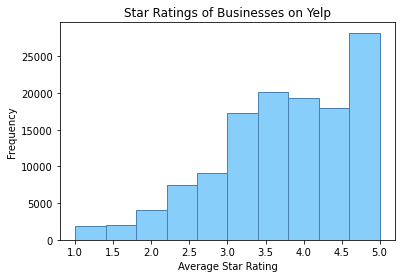

In [39]:
# Plot a histogram of the Star Ratings of Businesses on Yelp 
plt.hist(variables_df['Average Star Rating'], color='lightskyblue', edgecolor='steelblue')
plt.title("Star Ratings of Businesses on Yelp")
plt.xlabel("Average Star Rating")
plt.ylabel("Frequency")
plt.show()

From the histogram above, we can also confirm that the star ratings of businesses on Yelp is negatively skewed, as we can see a tail forming on the left side. This indicates that on average, there are more businesses with high star ratings, however, there are some businesses that have very low ratings, which pull down the average rating.

Text(0.5, 1.0, 'Number of Reviews for Businesses on Yelp')

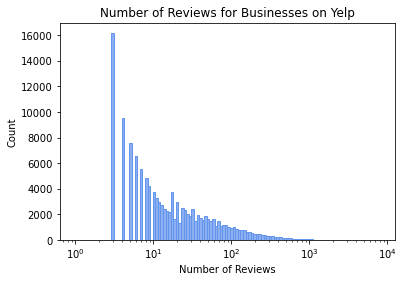

In [40]:
# Plot the number of reviews for businesses on yelp
# since there is such a large range of values, we will be using a log scale 
ax = sns.histplot(data=variables_df, x='Number of Reviews', color='cornflowerblue', edgecolor='cornflowerblue',
                  log_scale=True)
ax.set_title('Number of Reviews for Businesses on Yelp')

From the histogram above we can see that the number of reviews for a business is very heavily skewed. Even with the log scale, we can see a very long right tail, which indicates that it is positively skewed. This means that there are a very small number of businesses who have a very large number of reviews, which causes the average to be higher than the median. 

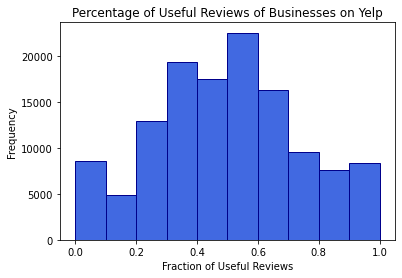

In [41]:
# Plot a histogram of the % Useful Reviews
plt.hist(variables_df['% Useful Reviews'], color='royalblue', edgecolor='darkblue')
plt.title("Percentage of Useful Reviews of Businesses on Yelp")
plt.xlabel("Fraction of Useful Reviews")
plt.ylabel("Frequency")
plt.show()

From the plot above, we can see that the percentage of useful reviews for businesses is normally distributed, as it appears in a bell curve. This means that a more businesses can be found with percentages of useful reviews close to the mean. That would mean that there are less businesses that would have very low or very high percentages of useful reviews.

#### NOTE: Explainations for the plots of  Percentage Funny and Cool Reviews will be shown after the last Cool plot, as the plots have many similarities

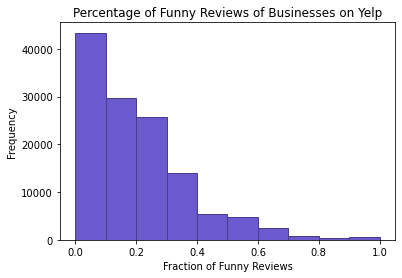

In [42]:
# Plot a histogram of the % Funny Reviews
plt.hist(variables_df['% Funny Reviews'], color='slateblue', edgecolor='darkslateblue')
plt.title("Percentage of Funny Reviews of Businesses on Yelp")
plt.xlabel("Fraction of Funny Reviews")
plt.ylabel("Frequency")
plt.show()

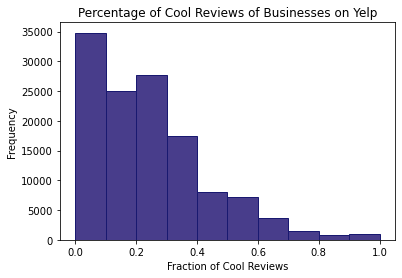

In [43]:
# Plot a histogram of the % Cool Reviews
plt.hist(variables_df['% Cool Reviews'], color='darkslateblue', edgecolor='midnightblue')
plt.title("Percentage of Cool Reviews of Businesses on Yelp")
plt.xlabel("Fraction of Cool Reviews")
plt.ylabel("Frequency")
plt.show()

After plotting the number funny and cool reviews, we can see that these two variables have a heavy positive skew. From these plots, we can see that a majority of businesses had a percentage of funny and cool reviews of 40% or lower. This means that for example, if a business had 10 reviews in total, we would probably find only 2-3 reviews that had upvotes for being funny or cool. From the right tail, we know that there are only a couple thousand of businesses that have very high percentages of funny or cool reviews. As a result of these high values, the mean is greater than the median. 

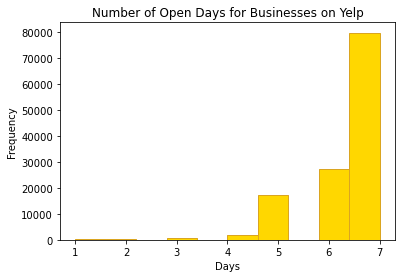

In [44]:
# Plot the Number of Open Days for Restaurants on Yelp
plt.hist(variables_df['days_open'], color='gold', edgecolor='goldenrod')
plt.title("Number of Open Days for Businesses on Yelp")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

From the figure above, we can also confirm that the number of open days for businesses on Yelp has negative skew. There is only a very small about of businesses who open for less than five days in comparison to the number of businesses that are open for six to seven days a week. Due to the low values, the average number of open days for businesses has slightly decreased in comparison to if there was no skew in the data.

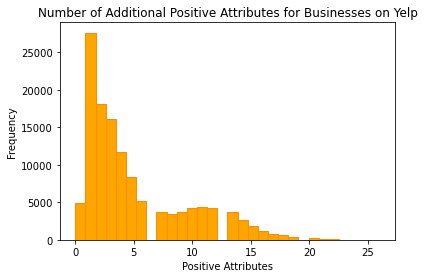

In [45]:
# Plot the Number of Additional Positive Attributes for Restaurants on Yelp
plt.hist(variables_df['num_true_attributes'], bins=30, color='orange', edgecolor='darkorange')
plt.title("Number of Additional Positive Attributes for Businesses on Yelp")
plt.xlabel("Positive Attributes")
plt.ylabel("Frequency")
plt.show()

From the histogram above, we can confirm that the number of additional positive attributes for bussinesses on Yelp is positively skewed as there is a tail forming on the right side. From this, we can say that a majority of businesses on Yelp only list around five or less additional positive attributes, while there may be a few businesses that list 20 or more additional attributes, thus increasing the average value. 

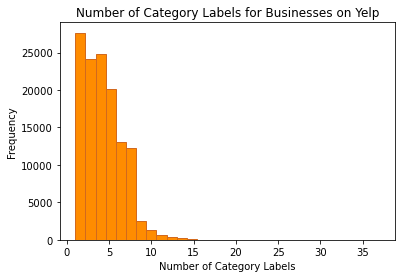

In [46]:
# Number of Category Labels for Restaurants on Yelp
plt.hist(variables_df['num_categories'], bins=30, color='darkorange', edgecolor='chocolate')
plt.title("Number of Category Labels for Businesses on Yelp")
plt.xlabel("Number of Category Labels")
plt.ylabel("Frequency")
plt.show()

Finally, from the last histogram, we can see that number of category labels for businesses on Yelp has a very heavy positive skewed. Most businesses only fall into 10 or less categories, however, there may be a few businesses that fall into over 35 categories, which causes the long right tail, and increased average. 

### Plots of the Relationship Between Y and Different Xs

Text(0.5, 1.0, 'Average Star Rating vs Review Count for Businesses on Yelp')

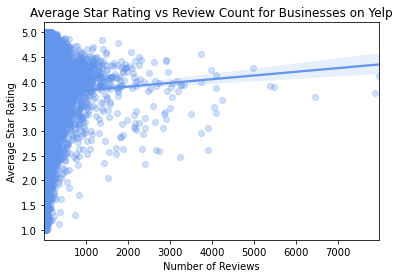

In [47]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='Number of Reviews', y='Average Star Rating', 
                 data=variables_df, color='cornflowerblue', scatter_kws={'alpha':0.3})
ax.set_title('Average Star Rating vs Review Count for Businesses on Yelp')

After plotting a linear regression, we can see that there is a positive trend between review count and star rating. Therefore, we can expect that as the number of reviews for a business increases, we will see an increase in the average star rating of the business. From this, we can assume that a majority of reviews tend to be more positive than negative. 

Text(0.5, 0, 'Fraction of Useful Reviews')

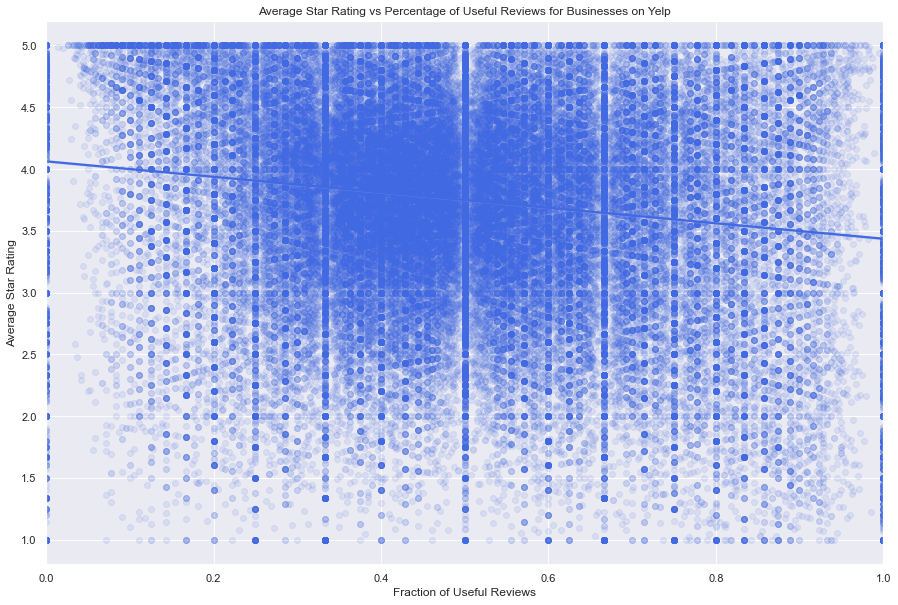

In [133]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='% Useful Reviews', y='Average Star Rating', 
                 data=variables_df, color='royalblue', scatter_kws={'alpha':0.1})
ax.set_title('Average Star Rating vs Percentage of Useful Reviews for Businesses on Yelp')
ax.set_xlabel('Fraction of Useful Reviews')

After plotting the regression of the percentage of useful reviews, we can see that a higher number of useful reviews correponds with a slightly lower star rating. Since the trend line pointing downwards, we can say that as the number of useful reviews for a business increases, we can expect a slightly lower star rating. This can imply that useful reviews are a little bit more likely to be negative than positive, as it is related with lower star ratings for businesses. 

Text(0.5, 0, 'Fraction of Funny Reviews')

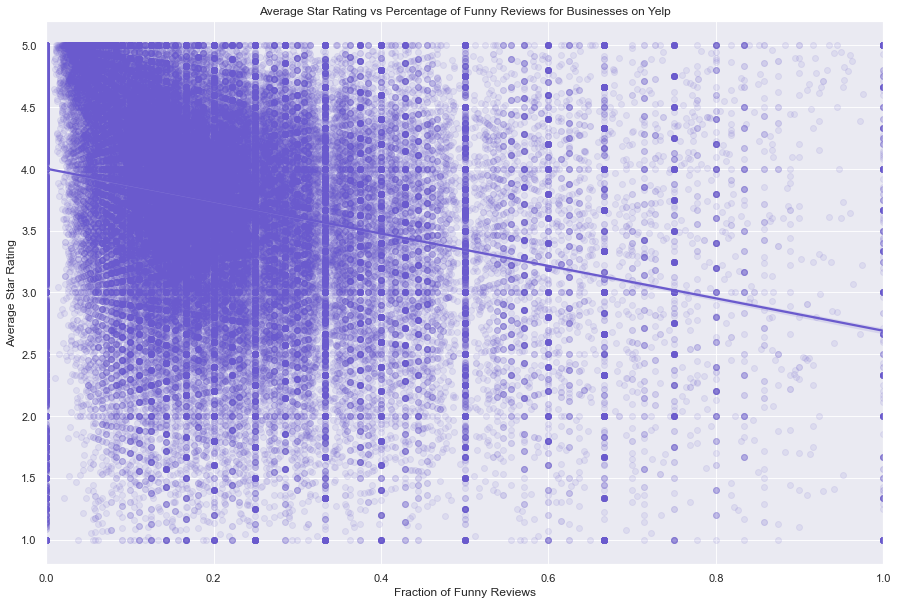

In [134]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='% Funny Reviews', y='Average Star Rating', 
                 data=variables_df, color='slateblue', scatter_kws={'alpha':0.1})
ax.set_title('Average Star Rating vs Percentage of Funny Reviews for Businesses on Yelp')
ax.set_xlabel('Fraction of Funny Reviews')

After plotting the percentage of funny reviews we can see that there is a negative trend between number of funny reviews and the average star rating of businesses. Therefore, we can associate funny reviews to be more negative as it tends to relate to lower star ratings.

Text(0.5, 0, 'Fraction of Cool Reviews')

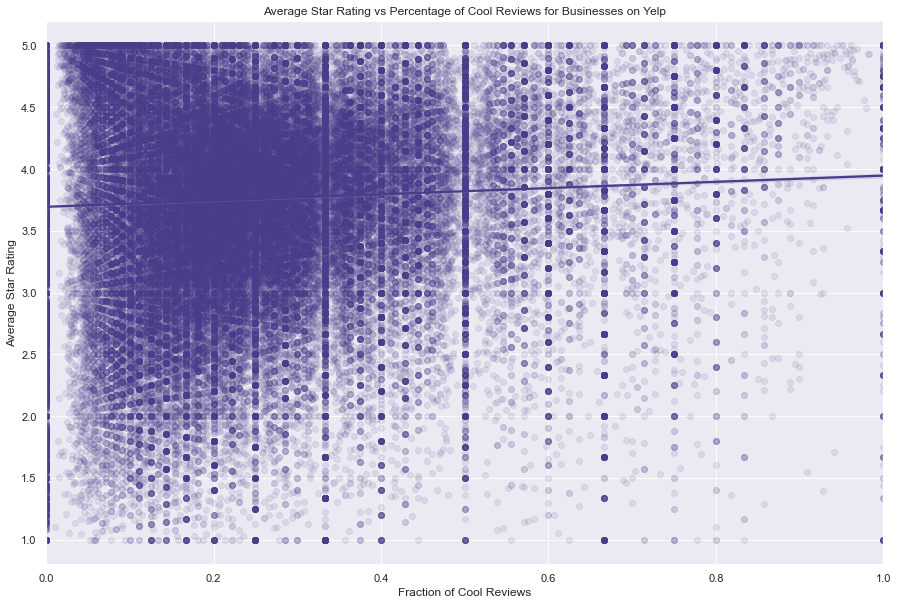

In [135]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='% Cool Reviews', y='Average Star Rating', 
                 data=variables_df, color='darkslateblue', scatter_kws={'alpha':0.1})
ax.set_title('Average Star Rating vs Percentage of Cool Reviews for Businesses on Yelp')
ax.set_xlabel('Fraction of Cool Reviews')

The regression here shows that there is a positive trend between percentage of cool reviews and star rating for a business, thus we can assume that cool reviews tend to be more positive.

Text(0.5, 1.0, 'Average Star Rating vs Number of Days Open for Businesses on Yelp')

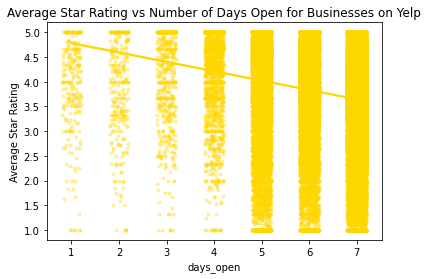

In [51]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='days_open', y='Average Star Rating', 
                 data=variables_df, color='gold', 
                 x_jitter=0.2, marker=".", scatter_kws={'alpha':0.3})
ax.set_title('Average Star Rating vs Number of Days Open for Businesses on Yelp')

From this plot, we can see that the star rating decreases as the number of days open increases. This seems strange but this coulde be due to the small number of businesses open for less days, resulting in higher ratings as there could be less reviews in general.

Text(0.5, 1.0, 'Average Star Rating vs Number of True Attributes for Businesses on Yelp')

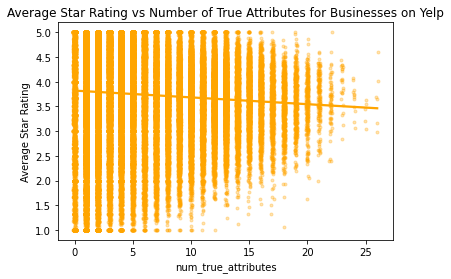

In [52]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='num_true_attributes', y='Average Star Rating', 
                 data=variables_df, color='orange', x_jitter=0.1, 
                 marker=".", scatter_kws={'alpha':0.3})
ax.set_title('Average Star Rating vs Number of True Attributes for Businesses on Yelp')

From this plot, we can see that there is a slight negative trend between the number of true attributes and the star rating. Therefore, as the number of true attributes increase, we tend to see businesses with lower star ratings. 

Text(0.5, 1.0, 'Average Star Rating vs Number of Categories for Businesses on Yelp')

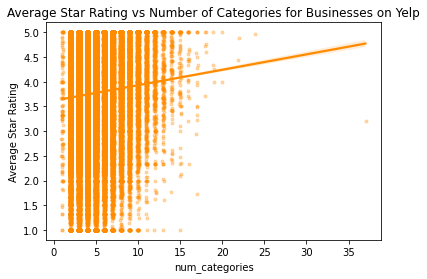

In [53]:
# collapse the observations in each bin to estimate central tendency with confidence interval 
# plot the regression 

ax = sns.regplot(x='num_categories', y='Average Star Rating', 
                 data=variables_df, color='darkorange', 
                 x_jitter=0.1, marker=".", scatter_kws={'alpha':0.3})
ax.set_title('Average Star Rating vs Number of Categories for Businesses on Yelp')

Finally, from the last plot, we can see that there is a large positive trend. As the number of categories for a business increases, the average star rating tends to increase as well. 

# Project Two 

## THE MESSAGE

The star rating of a business on Yelp is determined by averaging the star ratings from individual reviews. These reviews are further based on specific qualities of a business. Due to these two points, the purpose of this paper is to determine the relationship between the quality of both a business’ reviews and the business itself, with its corresponding overall star rating. By analyzing the relationship, we can potentially build a model to predict a business’ star rating based on its reviews and its other characteristics. 

### Webscrapping to isolate data on US Businesses

In [54]:
# this step is needed before we plot our main message plots:
# first we will webscrape 
# Statistic Canada to get a dataframe on US states and their abbreviations
# once we have the dataframe we can merge with the gbID_year 
# so we can filter to only businesses in the US

import requests
import pandas as pd
from bs4 import BeautifulSoup

web_url2 = 'https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971'
response2 = requests.get(web_url2)

In [55]:
soup_object2 = BeautifulSoup(response2.content)

In [56]:
# scrape the table
data_table_a = soup_object2.find_all('table')[0]

In [57]:
all_values_a = data_table_a.find_all('tr')

In [58]:
names_df = pd.DataFrame(columns=['State', 'Abbreviation', 'Alpha code'])

i = 0

for row in all_values_a[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    
    # Pick only the text part from the <td> tag
    State = values[0].text
    Abbrv = values[1].text
    alc = values[2].text

    names_df.loc[i] = [State, Abbrv, alc] # Store it in the dataframe as a row
    i += 1

In [59]:
# rename the abbreviation column so that we can merge the data onto our other dataframes
names_df = names_df.rename(columns={'Alpha code': 'state'})

In [60]:
# Show the resulting DataFrame
names_df

State Abbreviation state
0                Alabama         Ala.    AL
1                 Alaska                 AK
2                Arizona        Ariz.    AZ
3               Arkansas         Ark.    AR
4             California       Calif.    CA
5               Colorado        Colo.    CO
6            Connecticut        Conn.    CT
7               Delaware         Del.    DE
8   District of Columbia         D.C.    DC
9                Florida         Fla.    FL
10               Georgia          Ga.    GA
11                Hawaii                 HI
12                 Idaho                 ID
13              Illinois         Ill.    IL
14               Indiana         Ind.    IN
15                  Iowa                 IA
16                Kansas        Kans.    KS
17              Kentucky          Ky.    KY
18             Louisiana                 LA
19                 Maine          Me.    ME
20              Maryland          Md.    MD
21         Massachusetts        Mass.    MA
22              Michigan        Mich.    MI
23             Minnesota        Minn.    MN
24           Mississippi        Miss.    MS
25              Missouri          Mo.    MO
26               Montana        Mont.    MT
27              Nebraska        Nebr.    NE
28                Nevada         Nev.    NV
29         New Hampshire         N.H.    NH
30            New Jersey         N.J.    NJ
31            New Mexico       N.Mex.    NM
32              New York         N.Y.    NY
33        North Carolina         N.C.    NC
34          North Dakota                 ND
35                  Ohio                 OH
36              Oklahoma        Okla.    OK
37                Oregon         Ore.    OR
38          Pennsylvania        Penn.    PA
39          Rhode Island         R.I.    RI
40        South Carolina         S.C.    SC
41          South Dakota                 SD
42             Tennessee        Tenn.    TN
43                 Texas         Tex.    TX
44                  Utah                 UT
45               Vermont          Vt.    VT
46              Virginia          Va.    VA
47            Washington        Wash.    WA
48         West Virginia        W.Va.    WV
49             Wisconsin         Wis.    WI
50               Wyoming         Wyo.    WY

In [61]:
# merge the names and abbreviations with gbID_year then drop all 
# rows with NaNS this way we can make a dataframe with 
# just businesses in the US
gbID_year = pd.merge(gbID_year, names_df, how='left', on='state').dropna()

In [62]:
# show the dataframe
gbID_year

business_id  year  Average Star Rating  \
13      --7zmmkVg-IMGaXbuVd0SQ  2014             4.000000   
14      --7zmmkVg-IMGaXbuVd0SQ  2015             3.933333   
15      --7zmmkVg-IMGaXbuVd0SQ  2016             4.142857   
16      --7zmmkVg-IMGaXbuVd0SQ  2017             3.611111   
17      --7zmmkVg-IMGaXbuVd0SQ  2018             3.833333   
...                        ...   ...                  ...   
614622  zzwicjPC9g246MK2M1ZFBA  2017             2.750000   
614623  zzwicjPC9g246MK2M1ZFBA  2018             3.272727   
614624  zzzaIBwimxVej4tY6qFOUQ  2012             3.500000   
614625  zzzaIBwimxVej4tY6qFOUQ  2013             3.380952   
614626  zzzaIBwimxVej4tY6qFOUQ  2014             3.545455   

        Number of Useful Reviews  Number of Funny Reviews  \
13                             0                        0   
14                             8                        2   
15                             9                        6   
16                            10                        8   
17                             4                        4   
...                          ...                      ...   
614622                         1                        1   
614623                         1                        3   
614624                         6                        3   
614625                        13                        4   
614626                         7                        1   

        Number of Cool Reviews  Number of Reviews            name  \
13                           0                  1  Primal Brewery   
14                           8                 15  Primal Brewery   
15                           6                 14  Primal Brewery   
16                           9                 18  Primal Brewery   
17                           4                  6  Primal Brewery   
...                        ...                ...             ...   
614622                       0                  8         Sizzler   
614623                       1                 11         Sizzler   
614624                       2                  6       Guthrie's   
614625                       3                 21       Guthrie's   
614626                       1                 11       Guthrie's   

       neighborhood                   address  ... stars  review_count  \
13                   16432 Old Statesville Rd  ...   4.0          54.0   
14                   16432 Old Statesville Rd  ...   4.0          54.0   
15                   16432 Old Statesville Rd  ...   4.0          54.0   
16                   16432 Old Statesville Rd  ...   4.0          54.0   
17                   16432 Old Statesville Rd  ...   4.0          54.0   
...             ...                       ...  ...   ...           ...   
614622                 1050 S Country Club Dr  ...   3.0          63.0   
614623                 1050 S Country Club Dr  ...   3.0          63.0   
614624    Northwest       6728 W Cheyenne Ave  ...   3.5          38.0   
614625    Northwest       6728 W Cheyenne Ave  ...   3.5          38.0   
614626    Northwest       6728 W Cheyenne Ave  ...   3.5          38.0   

        is_open                                         attributes  \
13          1.0  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
14          1.0  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
15          1.0  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
16          1.0  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
17          1.0  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
...         ...                                                ...   
614622      1.0  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
614623      1.0  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
614624      0.0  {'Alcohol': 'none', 'Ambience': '{'romantic': ...   
614625      0.0  {'Alcohol': 'none', 'Ambience': '{'romantic': ...   
614626      0.0  {'Alcohol': 'none', 'Ambience': '{'romantic': ..

### Group the Dataframe by US State 

In [63]:
# Group By State and Year to find average number of stars 
gbST_year = gbID_year[['state', 'State', 'year', 'Average Star Rating']].copy()
gbST_year = gbST_year.groupby(['state', 'State', 'year']).mean().reset_index()

In [64]:
# create another groupby to find the 
# number of each kind of review for each state in each year
gbSt_y = gbID_year[['state', 'State', 'year', 
                   'Number of Useful Reviews', 
                   'Number of Funny Reviews', 
                   'Number of Cool Reviews', 
                    'Number of Reviews']].copy()
gbSt_y = gbSt_y.groupby(['state', 'State', 'year']).sum().reset_index()

In [65]:
# merge the two groupbys into one dataframe
gbST_year = pd.merge(gbST_year, gbSt_y, how='left', on=['state', 'State', 'year'])

In [66]:
# create new columns for percentage of each kind of review
gbST_year['% Useful Reviews'] = gbST_year['Number of Useful Reviews']/gbST_year['Number of Reviews']
gbST_year['% Funny Reviews'] = gbST_year['Number of Funny Reviews']/gbST_year['Number of Reviews']
gbST_year['% Cool Reviews'] = gbST_year['Number of Cool Reviews']/gbST_year['Number of Reviews']

In [67]:
gbST_year

state      State  year  Average Star Rating  Number of Useful Reviews  \
0      AL    Alabama  2016             4.000000                         1   
1      AL    Alabama  2017             4.000000                         1   
2      AL    Alabama  2018             1.000000                         0   
3      AR   Arkansas  2014             5.000000                         0   
4      AR   Arkansas  2015             5.000000                         1   
..    ...        ...   ...                  ...                       ...   
201    WI  Wisconsin  2014             3.672993                      7743   
202    WI  Wisconsin  2015             3.685875                      8790   
203    WI  Wisconsin  2016             3.695373                     10198   
204    WI  Wisconsin  2017             3.682989                      8082   
205    WI  Wisconsin  2018             3.657955                      3270   

     Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                          1                       1                  1   
1                          0                       1                  2   
2                          0                       0                  1   
3                          0                       0                  1   
4                          0                       2                  2   
..                       ...                     ...                ...   
201                     2774                    3533              13865   
202                     2757                    5388              16846   
203                     2746                    6590              18903   
204                     2021                    5609              19228   
205                      667                    2473               9810   

     % Useful Reviews  % Funny Reviews  % Cool Reviews  
0            1.000000         1.000000        1.000000  
1            0.500000         0.000000        0.500000  
2            0.000000         0.000000        0.000000  
3            0.000000         0.000000        0.000000  
4            0.500000         0.000000        1.000000  
..                ...              ...             ...  
201          0.558457         0.200072        0.254814  
202          0.521786         0.163659        0.319839  
203          0.539491         0.145268        0.348622  
204          0.420325         0.105107        0.291710  
205          0.333333         0.067992        0.252090  

[206 rows x 11 columns]

# Main Message Plot

### Plot the Average Star Rating of each State over the years

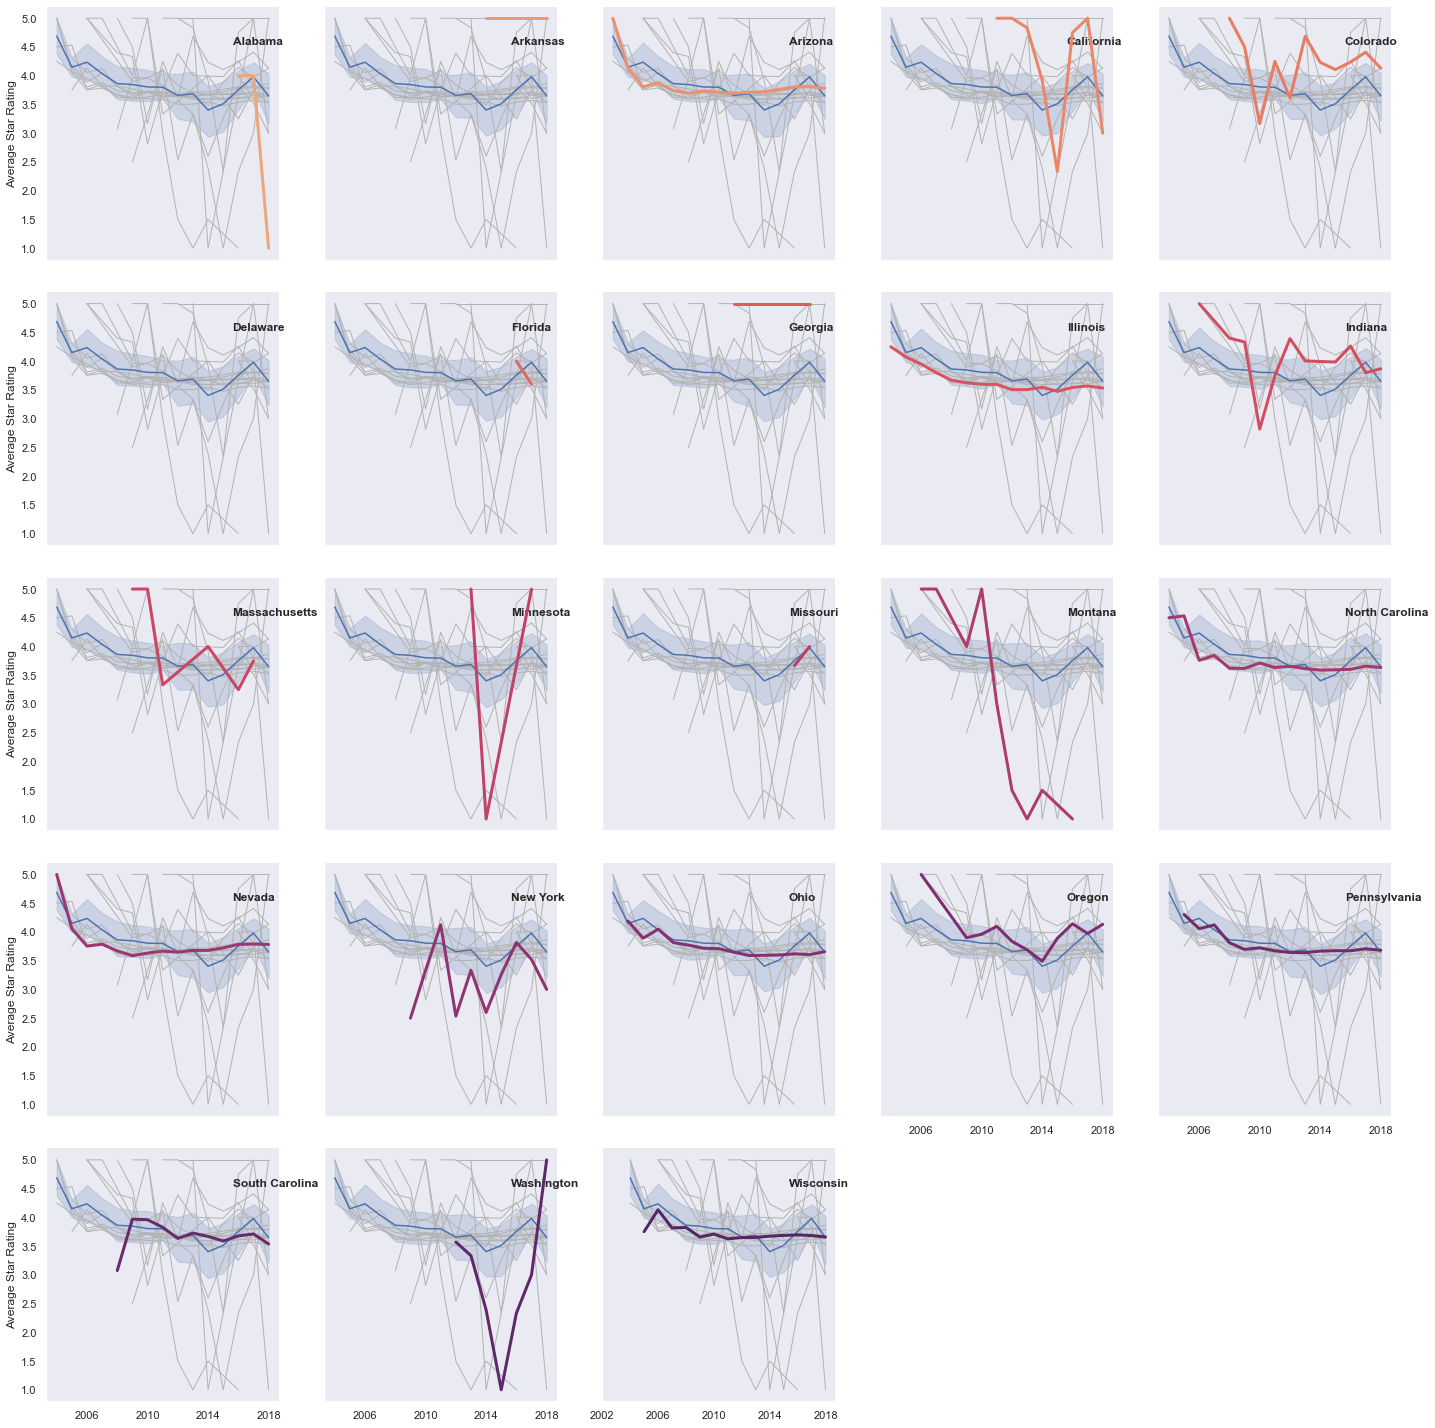

In [68]:
# plot the Average Star Rating of over the Years

sns.set_theme(style='dark')

plot = sns.relplot(x='year', y='Average Star Rating', kind='line', 
                   data=gbST_year, col='State', hue='State', palette='flare', zorder=5,
            col_wrap=5, height=4, aspect=1, linewidth=3, legend=False)

for state, ax in plot.axes_dict.items():

    ax.text(.8, .85, state, transform=ax.transAxes, 
            fontsize='medium', fontweight='demibold')
    
    sns.lineplot(
        data=gbST_year, x='year', y='Average Star Rating', units='State',
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    
    sns.lineplot(x='year', y='Average Star Rating', data=gbST_year,
                ax=ax)

ax.set_xticks(ax.get_xticks()[::2])

plot.set_titles('')
plot.set_axis_labels('', 'Average Star Rating')
plot.tight_layout()

### Plot the Percentage of Useful Reviews VS Average Star Rating from 2004-2018

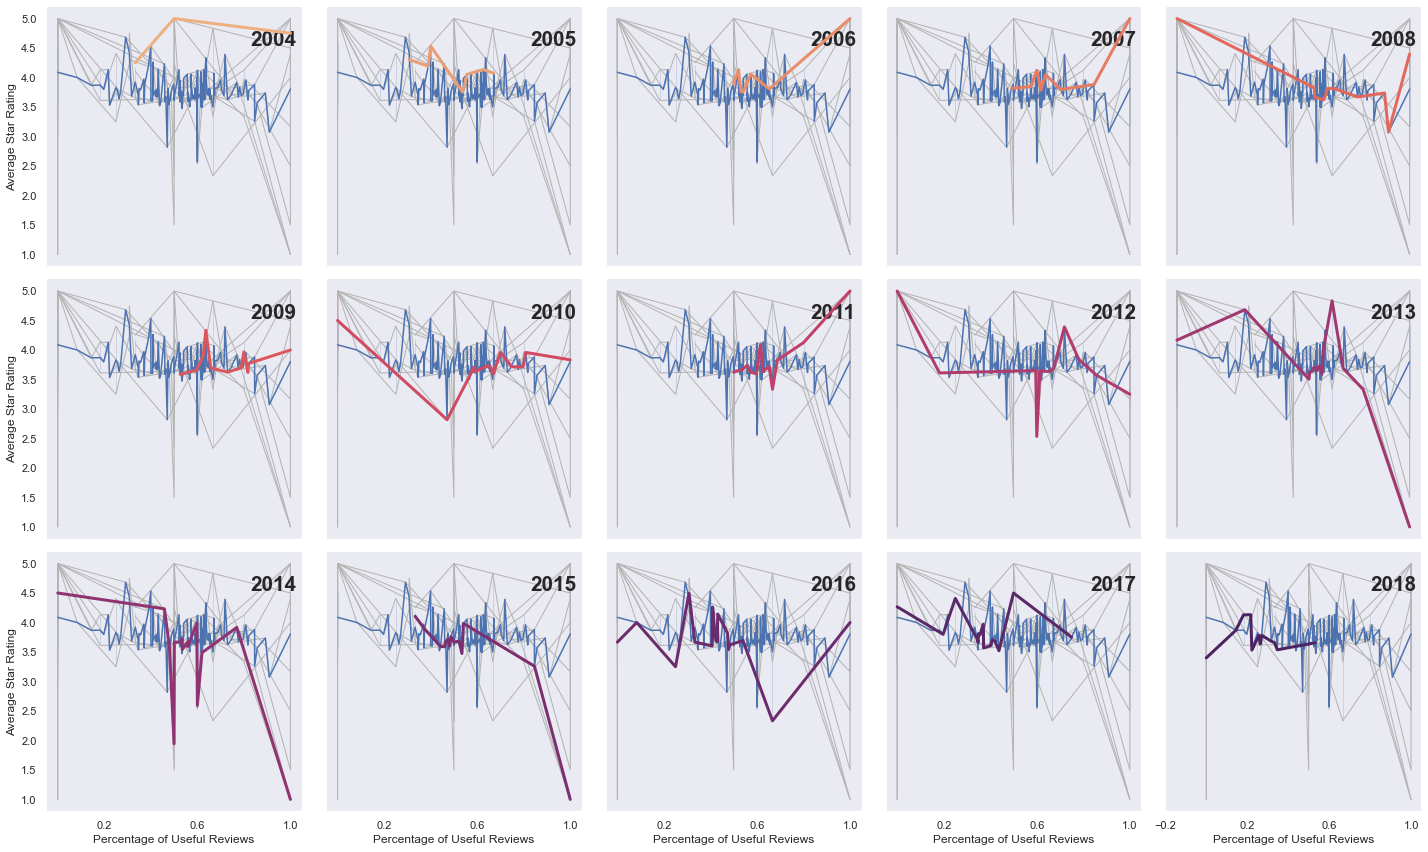

In [69]:
# Plot the Percentage of Useful Reviews VS Average Star Rating from 2004-2018

sns.set_theme(style='dark')

plot = sns.relplot(x='% Useful Reviews', y='Average Star Rating', kind='line', 
                   data=gbST_year, col='year', hue='year', palette='flare', zorder=5,
            col_wrap=5, height=4, aspect=1, linewidth=3, legend=False)

for year, ax in plot.axes_dict.items():
    
    ax.text(.8, .85, year, transform=ax.transAxes, 
            fontsize='xx-large', fontweight='demibold')
    
    sns.lineplot(
        data=gbST_year, x='% Useful Reviews', y='Average Star Rating', units='year',
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    
    sns.lineplot(x='% Useful Reviews', y='Average Star Rating', data=gbST_year,
                ax=ax)

ax.set_xticks(ax.get_xticks()[::2])

plot.set_titles('')
plot.set_axis_labels('Percentage of Useful Reviews', 'Average Star Rating')
plot.tight_layout()

## Mapping Star Rating and Review Density 

In [72]:
!pip install fiona

In [73]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

import math

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [76]:
# import the file for the US states 
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

In [77]:
# create a list of U.S States to remove from the map 
remove = ['Alaska', 'Hawaii', 'United States Virgin Islands',
          'Puerto Rico', 'Guam', 'Commonwealth of the Northern Mariana Islands', 
          'American Samoa']

In [78]:
# for each state in the list
# find the index in the state_df and record the index in a new list 

indexes = []
for state in remove:
    index = state_df.index[state_df['NAME'] == state].tolist()
    indexes.append(index[0])

In [79]:
# drop the states from the dataframe
state_df = state_df.drop(indexes).reset_index()

In [80]:
state_df

index STATEFP   STATENS     AFFGEOID GEOID STUSPS                  NAME  \
0       0      01  01779775  0400000US01    01     AL               Alabama   
1       2      04  01779777  0400000US04    04     AZ               Arizona   
2       3      08  01779779  0400000US08    08     CO              Colorado   
3       4      09  01779780  0400000US09    09     CT           Connecticut   
4       5      12  00294478  0400000US12    12     FL               Florida   
5       6      13  01705317  0400000US13    13     GA               Georgia   
6       7      16  01779783  0400000US16    16     ID                 Idaho   
7       8      18  00448508  0400000US18    18     IN               Indiana   
8       9      20  00481813  0400000US20    20     KS                Kansas   
9      10      22  01629543  0400000US22    22     LA             Louisiana   
10     11      25  00606926  0400000US25    25     MA         Massachusetts   
11     12      27  00662849  0400000US27    27     MN             Minnesota   
12     13      29  01779791  0400000US29    29     MO              Missouri   
13     14      30  00767982  0400000US30    30     MT               Montana   
14     15      32  01779793  0400000US32    32     NV                Nevada   
15     16      34  01779795  0400000US34    34     NJ            New Jersey   
16     17      36  01779796  0400000US36    36     NY              New York   
17     18      38  01779797  0400000US38    38     ND          North Dakota   
18     19      40  01102857  0400000US40    40     OK              Oklahoma   
19     20      42  01779798  0400000US42    42     PA          Pennsylvania   
20     21      45  01779799  0400000US45    45     SC        South Carolina   
21     22      46  01785534  0400000US46    46     SD          South Dakota   
22     23      48  01779801  0400000US48    48     TX                 Texas   
23     24      50  01779802  0400000US50    50     VT               Vermont   
24     25      54  01779805  0400000US54    54     WV         West Virginia   
25     27      05  00068085  0400000US05    05     AR              Arkansas   
26     28      06  01779778  0400000US06    06     CA            California   
27     29      10  01779781  0400000US10    10     DE              Delaware   
28     30      11  01702382  0400000US11    11     DC  District of Columbia   
29     32      17  01779784  0400000US17    17     IL              Illinois   
30     33      19  01779785  0400000US19    19     IA                  Iowa   
31     34      21  01779786  0400000US21    21     KY              Kentucky   
32     35      23  01779787  0400000US23    23     ME                 Maine   
33     36      24  01714934  0400000US24    24     MD              Maryland   
34     37      26  01779789  0400000US26    26     MI              Michigan   
35     38      28  01779790  0400000US28    28     MS           Mississippi   
36     39      31  01779792  0400000US31    31     NE              Nebraska   
37     40      33  01779794  0400000US33    33     NH         New Hampshire   
38     41      35  00897535  0400000US35    35     NM            New Mexico   
39     42      37  01027616  0400000US37    37     NC        North Carolina   
40     43      39  01085497  0400000US39    39     OH                  Ohio   
41     44      41  01155107  0400000US41    41     OR                Oregon   
42     45      44  01219835  0400000US44    44     RI          Rhode Island   
43     46      47  01325873  0400000US47    47     TN             Tennessee   
44     47      49  01455989  0400000US49    49     UT                  Utah   
45     48      51  01779803  0400000US51    51     VA              Virginia   
46     49      53  01779804  0400000US53    53     WA            Washington   
47     50      55  01779806  0400000US55    55     WI             Wisconsin   
48     55      56  01779807  0400000US56    56     WY               Wyoming   

   LSAD         ALAND        AWATER  \
0    00  13117

In [81]:
# to make a map, we will be using data that is grouped by state and year 
# create a copy of the dataframe and rename the state column 
# as STUSPS so that we can merge it with the map dataframe

map_data = gbST_year.copy().rename(columns={'state': 'STUSPS'})

In [82]:
# merge the data with the map dataframe 
merged_map = pd.merge(map_data, state_df, how='left', on='STUSPS')

In [83]:
# create a three new dataframes for data in 2004, 2010 and 2018
df_2004 = merged_map.loc[merged_map['year'] == 2004]
df_2011 = merged_map.loc[merged_map['year'] == 2010]
df_2018 = merged_map.loc[merged_map['year'] == 2018]

In [84]:
# create a map for each of the years 
map_2004 = gpd.GeoDataFrame(df_2004)
map_2011 = gpd.GeoDataFrame(df_2011)
map_2018 = gpd.GeoDataFrame(df_2018)

##### Note: Analysis of maps will be provided after all maps are outputted

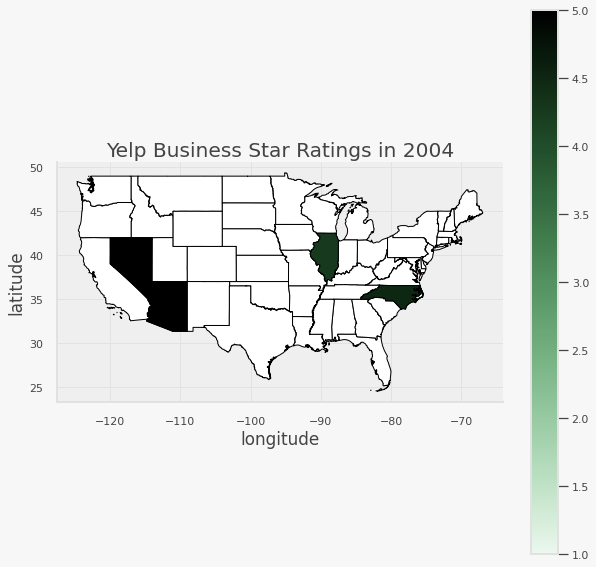

In [85]:
# plot the map with the rest of the US States
fig, gax = plt.subplots(figsize=(10,10))

c = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)

state_df.plot(ax=gax, edgecolor="black", color="white")
map_2004.plot(ax=gax, edgecolor='black', column='Average Star Rating', legend=True, cmap=c,
    vmin=1, vmax=5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Yelp Business Star Ratings in 2004')

plt.show()

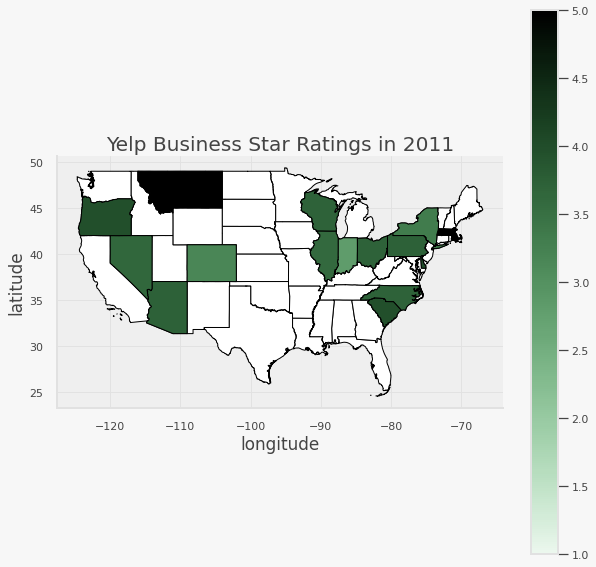

In [86]:
# plot the map with the rest of the US States
fig, gax = plt.subplots(figsize=(10,10))

c = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)

state_df.plot(ax=gax, edgecolor="black", color="white")
map_2011.plot(ax=gax, edgecolor='black', column='Average Star Rating', legend=True, cmap=c,
    vmin=1, vmax=5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Yelp Business Star Ratings in 2011')

plt.show()

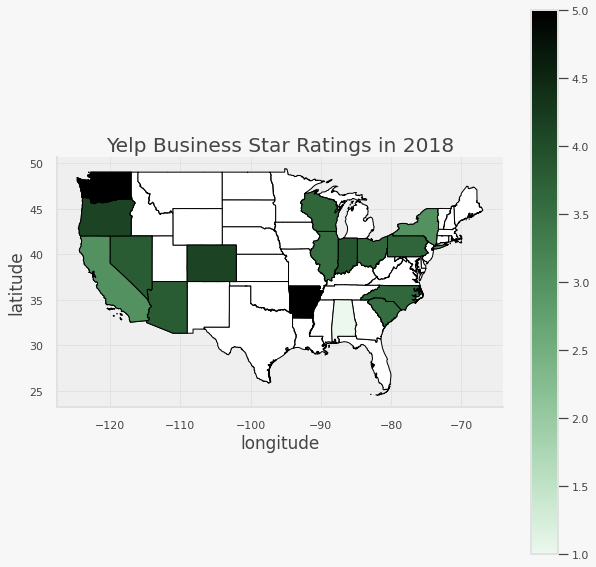

In [87]:
# plot the map with the rest of the US States
fig, gax = plt.subplots(figsize=(10,10))

c = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)

state_df.plot(ax=gax, edgecolor="black", color="white")
map_2018.plot(ax=gax, edgecolor='black', column='Average Star Rating', legend=True, cmap=c,
    vmin=1, vmax=5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Yelp Business Star Ratings in 2018')

plt.show()

Using the data on the star rating and time, we can create a map to see how the average star rating of individual US states has changed over time. The earliest records of Yelp ratings were in 2004 and the latest is in 2018. From the legend bar, we can see that dark green states have a very high average business star rating close to 5.0, while very light green states have low average star ratings close to 1. Over time, we can see that there are more and more states joining the Yelp review system. As the years’ pass, we can also see that the average business ratings tend to start off higher, then fall towards a rating of around 3.75. Due to the large aggregation of the dataset, this is expected as the possible range of ratings only spans from 1 to 5, while there could be thousands of businesses that are recorded for each state.        

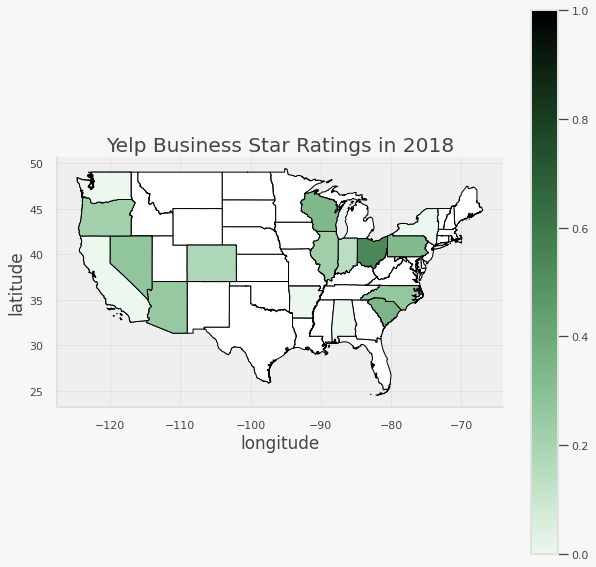

In [88]:
# We can also plot the percentage of Useful Reviews for each US State 
fig, gax = plt.subplots(figsize=(10,10))

c = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)

state_df.plot(ax=gax, edgecolor="black", color="white")
map_2018.plot(ax=gax, edgecolor='black', column='% Useful Reviews', legend=True, cmap=c,
    vmin=0, vmax=1)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Yelp Business Star Ratings in 2018')

plt.show()

# Project Three

## Choosing Additional Data to Enhance the Main Message

For the third part of the project, we will be webscraping data from online to enhance our 
main message. To determine more factors that may affect the star rating of a business, I thought that data on demographic characteristics such as age distribution by state, or income per capital by state would be able to enhance my paper. 

Data on age distribution by age can be found on the following link:
https://www.kff.org/other/state-indicator/distribution-by-age/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

To merge the data we can add the abbreviations to the states on the scrapped data, then merge the data onto the main dataframe using the abbreviated states as the key. 

For the data on income, I can use the website provided here:
https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income

I think I can merge the data in a similar way, using the abbreviation as the key. 

Finally, I believe that these two factors can enhance my paper, as I can look at the the relationship between age and income, on star rating. Could areas with more young people result in lower or higher star ratings? How about income? The follow part will explore webscrapping and new data. 

## Frequency of Running Program

The frequency of the program will probably be once per year, as the data is collected once a year through a census. A challenge with scrapping data from the age distribution is that the table is encoded using javascript, which I am not familiar with handling. Therefore, for the following part, we will be using the income data provided on wikipedia. 

## Data Scraping and Merging Data

##### Web scrapping the first table for longitudinal data on income per capita

In [89]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

# now we will scrape the Median Household Income by US State over the years from 
# the following url

web_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income'
response = requests.get(web_url)

In [90]:
soup_object = BeautifulSoup(response.content)

In [91]:
# scrape the first table from the same website 
data_table_3 = soup_object.find_all('table', 'wikitable sortable')[0]
all_values_3 = data_table_3.find_all('tr')

In [92]:
# create a function that will formate the values in the table properly 
def delete_comma(text, dollar_bool):
    """ Return a cleaned version of the text with out the commas and $ sign 
    """
    # if N\A, return the original text
    if 'N/A' in text:
        return text[:-1]
    
    # first strip the $ and \n at the end of the string if dollar_bool == True
    if dollar_bool == True:
        text = text[1:-1]
    else:
        text = text[:-1]
    
    # if length of number is shorter than 6, we need to remove one comma
    # else, we need to remove two commas
    if len(text) <= 7:
        index = text.index(',')
        result = text[:index] + text[index+1:]
        return int(result)
    else:
        for i in range(2):
            index = text.index(',')
            text = text[:index] + text[index+1:]
        return int(text)

In [93]:
# create the dataframe using data from the website 
income_df_3 = pd.DataFrame(columns=['State Rank', 'States and Washington, D.C.', 
                                    '2019', '2018', '2017', '2016', '2015', 
                                    '2014','2013', '2012', '2011', '2010', 
                                    'Average annual growth rate (current dollars) in 2010-2019, %'])
i = 0

for row in all_values_3[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    Rank = values[0].text
    
    if '\n' in Rank:
        Rank = ''
    
    if len(Rank) > 2:
        Rank = Rank[:-8]
    
    States = (values[1].text)[1:-1]
    y_2019 = delete_comma(values[2].text, True)
    y_2018 = delete_comma(values[3].text, True)
    y_2017 = delete_comma(values[4].text, True)
    y_2016 = delete_comma(values[5].text, True)
    y_2015 = delete_comma(values[6].text, True)
    y_2014 = delete_comma(values[7].text, True)
    y_2013 = delete_comma(values[8].text, True)
    y_2012 = delete_comma(values[9].text, True)
    y_2011 = delete_comma(values[10].text, True)
    y_2010 = delete_comma(values[11].text, True)
    gr = float((values[12].text)[:-2])
    
    
    income_df_3.loc[i] = [Rank, States, y_2019, y_2018, y_2017, 
                          y_2016, y_2015, y_2014, y_2013, y_2012, 
                          y_2011, y_2010, gr] # Store it in the dataframe as a row
    i += 1

In [94]:
# merge names_df with income_df_3 to get the abbreviations of each state
names_df = names_df.rename(columns={'State': 'States and Washington, D.C.'})
income_data = pd.merge(income_df_3, names_df, how='left', on='States and Washington, D.C.')
income_data = income_data.drop(columns='Abbreviation').rename(columns={'Alpha code': 'state'})

In [95]:
# show the scrapped table
income_data

State Rank States and Washington, D.C.   2019   2018   2017   2016   2015  \
0                           United States  65712  63179  60336  57617  55775   
1           –            Washington, D.C.  92266  85203  82372  75506  75628   
2           1                    Maryland  86738  83242  80776  78945  75847   
3           2               Massachusetts  85843  79835  77385  75297  70628   
4           3                  New Jersey  85751  81740  80088  76126  72222   
5           4                      Hawaii  83102  80212  77765  74511  73486   
6           5                  California  80440  75277  71805  67739  64500   
7           6                 Connecticut  78833  76348  74168  73433  71346   
8           7                  Washington  78687  74073  70979  67106  64129   
9           8               New Hampshire  77933  74991  73381  70936  70303   
10          9                    Colorado  77127  71953  69117  65685  63909   
11         10                    Virginia  76456  72577  71535  68114  66262   
12         11                        Utah  75780  71414  65358  65977  62912   
13         12                      Alaska  75463  74346  73181  76440  73355   
14         13                   Minnesota  74593  70315  68388  65599  63488   
15         14                    New York  72108  67844  64894  62909  60850   
16         15                Rhode Island  71169  64340  63870  60596  58073   
17         16                    Delaware  70176  64805  62852  61757  61255   
18         17                    Illinois  69187  65030  62992  60960  59588   
19         18                      Oregon  67058  63426  60212  57532  54148   
20         19                     Wyoming  65003  61584  60434  59882  60214   
21         20                North Dakota  64577  63837  61843  60656  60557   
22         21                   Wisconsin  64168  60773  59305  56811  55638   
23         22                       Texas  64034  60629  59206  56565  55653   
24         23                Pennsylvania  63463  60905  59105  56907  55702   
25         24                      Nevada  63276  58646  58003  55180  52431   
26         25                    Nebraska  63229  59566  59970  56927  54996   
27         26                     Vermont  63001  60782  57513  57677  56990   
28         27                      Kansas  62087  58218  56422  54935  53906   
29         28                     Arizona  62055  59246  56581  53558  51492   
30         29                     Georgia  61980  58756  56183  53559  51244   
31         30                        Iowa  61691  59955  58570  56247  54736   
32         31                       Idaho  60999  55583  52225  51807  48275   
33         32                    Michigan  59584  56697  54909  52491  51084   
34         33                South Dakota  59533  56274  56521  54467  53017   
35         34                     Florida  59227  55462  52594  50860  49426   
36         35                       Maine  58924  55602  55277  53079  51494   
37         36                        Ohio  58642  56111  54021  52344  51075   
38         37                     Indiana  57603  55746  54181  52314  50532   
39         38                    Missouri  57409  54478  53578  51746  50238   
40         39              North Carolina  57341  53855  52752  50584  47830   
41         40                     Montana  57153  55328  53386  50027  49509   
42         41              South Carolina  56227  52306  50570  49501  47238   
43         42                   Tennessee  56071  52375  51340  48547  47275   
44         43                    Oklahoma  54449  51924  50051  49176  48568   
45         44                    Kentucky  52295  50247  48375  46659  45215   
46         45                  New Mexico  51945  47169  46744  46748  45382   
47         46                     Alabama  51734  49861  48123  46257  44765   
48         47                   Louisiana  51073  47905  46145  45146  45727   
49 

##### Merge Data with Other Variables

In [96]:
# first we need to change the format of the income dataframe
# so that we can merge it with the other variables

changed_income = income_data.copy()
changed_income = pd.melt(changed_income, 
                         id_vars=['States and Washington, D.C.'], 
                         value_vars=['2019', '2018', '2017', 
                                     '2016', '2015', '2014', 
                                     '2013', '2012', '2011', '2010'])
changed_income = changed_income.rename(columns={'variable': 'year', 
                                                'value': 'Median Household Income'})

In [97]:
# merge the abbreviations back onto the dataframe
changed_income = pd.merge(changed_income, 
                          names_df, 
                          how='left', 
                          on='States and Washington, D.C.')
changed_income = changed_income.drop(columns=['Abbreviation']).rename(columns={'Alpha code': 'state'})
changed_income['year'] = changed_income['year'].astype(int)

In [98]:
# merge the data with our other variables in gbST_year
line_df = pd.merge(gbST_year, changed_income, how='left', on=['state', 'year'])

In [99]:
# show the resulting Dataframe
line_df

state      State  year  Average Star Rating  Number of Useful Reviews  \
0      AL    Alabama  2016             4.000000                         1   
1      AL    Alabama  2017             4.000000                         1   
2      AL    Alabama  2018             1.000000                         0   
3      AR   Arkansas  2014             5.000000                         0   
4      AR   Arkansas  2015             5.000000                         1   
..    ...        ...   ...                  ...                       ...   
201    WI  Wisconsin  2014             3.672993                      7743   
202    WI  Wisconsin  2015             3.685875                      8790   
203    WI  Wisconsin  2016             3.695373                     10198   
204    WI  Wisconsin  2017             3.682989                      8082   
205    WI  Wisconsin  2018             3.657955                      3270   

     Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                          1                       1                  1   
1                          0                       1                  2   
2                          0                       0                  1   
3                          0                       0                  1   
4                          0                       2                  2   
..                       ...                     ...                ...   
201                     2774                    3533              13865   
202                     2757                    5388              16846   
203                     2746                    6590              18903   
204                     2021                    5609              19228   
205                      667                    2473               9810   

     % Useful Reviews  % Funny Reviews  % Cool Reviews  \
0            1.000000         1.000000        1.000000   
1            0.500000         0.000000        0.500000   
2            0.000000         0.000000        0.000000   
3            0.000000         0.000000        0.000000   
4            0.500000         0.000000        1.000000   
..                ...              ...             ...   
201          0.558457         0.200072        0.254814   
202          0.521786         0.163659        0.319839   
203          0.539491         0.145268        0.348622   
204          0.420325         0.105107        0.291710   
205          0.333333         0.067992        0.252090   

    States and Washington, D.C. Median Household Income  
0                       Alabama                   46257  
1                       Alabama                   48123  
2                       Alabama                   49861  
3                      Arkansas                   41262  
4                      Arkansas                   41995  
..                          ...                     ...  
201                   Wisconsin                   52622  
202                   Wisconsin                   55638  
203                   Wisconsin                   56811  
204                   Wisconsin                   59305  
205                   Wisconsin                   60773  

[206 rows x 13 columns]

In [100]:
# convert the values in Median Household Income into integers 
# first drop na values 
line_df_1 = line_df.dropna()
line_df_1['Median Household Income'] = line_df_1['Median Household Income'].astype(int)

<ipython-input-100-a49b414e4632>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_df_1['Median Household Income'] = line_df_1['Median Household Income'].astype(int)


## Plotting New Relationships

In [101]:
# now we can plot the average star rating against the new data on income by state/territory
# make a copy of the dataframe
new_focus = line_df_1.copy()

In [102]:
# Create a new groupby State so we can plot the relationship
Mincome_df = new_focus.groupby(['State']).mean()
Mincome_df.reset_index(inplace=True)

In [103]:
Mincome_df

State         year  Average Star Rating  \
0          Alabama  2017.000000             3.000000   
1          Arizona  2014.000000             3.748466   
2         Arkansas  2016.000000             5.000000   
3       California  2014.500000             4.229167   
4         Colorado  2014.000000             4.091713   
5         Delaware  2010.000000             4.000000   
6          Florida  2016.500000             3.800000   
7          Georgia  2015.000000             5.000000   
8         Illinois  2014.000000             3.540072   
9          Indiana  2014.000000             3.873869   
10   Massachusetts  2013.600000             3.866667   
11       Minnesota  2014.666667             3.666667   
12        Missouri  2016.500000             3.833333   
13         Montana  2012.666667             2.166667   
14          Nevada  2014.000000             3.709140   
15        New York  2014.000000             3.280460   
16  North Carolina  2014.000000             3.633511   
17            Ohio  2014.000000             3.637499   
18          Oregon  2014.000000             3.912060   
19    Pennsylvania  2014.000000             3.675521   
20  South Carolina  2014.000000             3.703005   
21      Washington  2015.000000             2.946712   
22       Wisconsin  2014.000000             3.669926   

    Number of Useful Reviews  Number of Funny Reviews  Number of Cool Reviews  \
0                   0.666667                 0.333333                0.666667   
1               81783.888889             33506.222222            39433.777778   
2                   0.200000                 0.000000                0.600000   
3                   3.250000                 1.250000                1.625000   
4                   7.777778                 2.222222                4.111111   
5                   0.000000                 0.000000                0.000000   
6                   0.500000                 0.000000                1.000000   
7                   0.000000                 0.000000                0.000000   
8                1676.333333               573.444444              692.777778   
9                  41.444444                 9.222222               16.222222   
10                  1.400000                 1.000000                0.400000   
11                  0.333333                 0.000000                0.000000   
12                  0.500000                 0.500000                0.000000   
13                  0.833333                 0.166667                0.000000   
14              90397.888889             43899.666667            53081.555556   
15                  5.666667                 1.777778                2.888889   
16              15028.222222              6191.111111             7262.555556   
17              13440.000000              6444.888889             7244.555556   
18                 38.333333                10.666667               18.000000   
19              11628.888889              4314.333333             5973.666667   
20                515.777778               164.555556              204.888889   
21                  2.571429                 1.000000                0.714286   
22               5918.333333              1892.222222             3369.777778   

    Number of Reviews  % Useful Reviews  % Funny Reviews  % Cool Reviews  \
0            1.333333          0.500000         0.333333        0.500000   
1       180615.000000          0.514405         0.225527        0.260987   
2            3.800000          0.100000         0.000000        0.240000   
3            6.000000          0.592949         0.309295        0.413462   
4           25.000000          0.389407         0.099184        0.171989   
5            5.000000          0.000000         0.000000        0.000000   
6            8.500000          0.041667         0.000000        0.083333   
7            1.000000          0.000000         0.000000        0.000000   
8         3423.666667          0.510222

[Text(0.5, 1.0, 'Average Star Rating of States VS Median Household Income')]

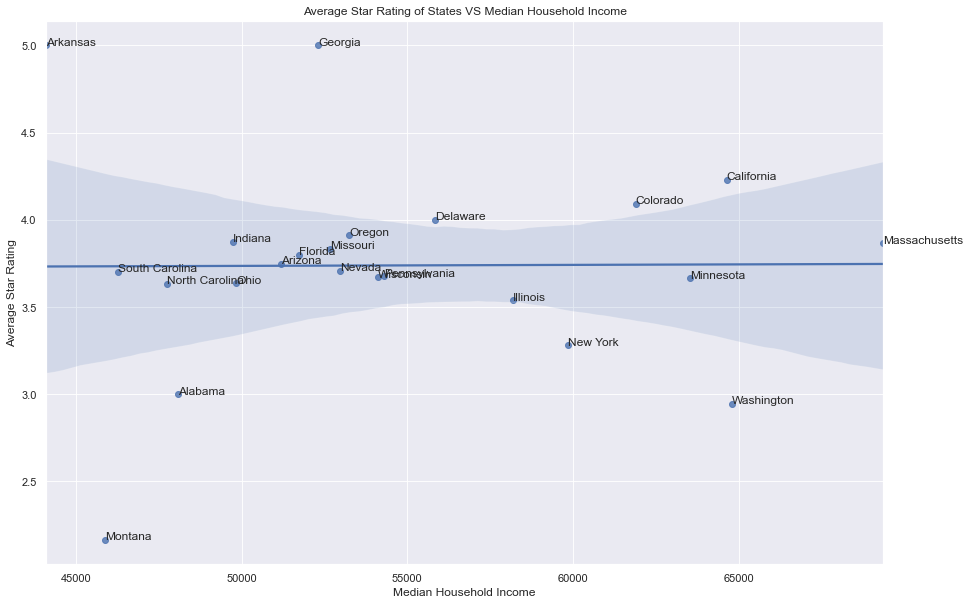

In [104]:
# Plot the Relationship between the new variable and Average Star Rating Per State
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.regplot(x='Median Household Income', 
                 y='Average Star Rating', 
                 data=Mincome_df)

states = Mincome_df['State']
MI = Mincome_df['Median Household Income']
stars = Mincome_df['Average Star Rating']

for i, state in enumerate(states):
    plt.annotate(state, (MI[i], stars[i]))
    
ax.set(title
       ='Average Star Rating of States VS Median Household Income')

From this plot, we can see that the line plotting the relationship between median household income and average star rating is very flat, which could indicate that there is no relationship between the two variables. We can see that some US states that have very low median household income have very high average star ratings, while others have very low ratings. Similarly, on the high end of median household income, the average star rating can vary. Near the middle values of median household income, more states tend to have average star ratings of about 3.75 stars

# Final Project

#### Linear VS Non Linear Relationship

For this project, we are examining the relationship between seven predictive variables and the outcome variable, average star rating. Before moving to the OLS regressions, I think that the economic relationship between my Y and X variables will not be linear. According to the definition, a non-linear relationship does not have proportionate outputs given its inputs. In addition, a linear relationship's equation can only have two variables or less. Since the regression model will be using all 8 variables, the resulting equation that represents the average star rating will not be linear. 

#### Choice of X Variables

The purpose of this paper is to examine if there are specific factors related to a business's online presence and its respective star rating. The first three variables I decided to choose are the percentage of useful, funny, and cool reviews. Reviews play a major role in building a business's reputation through online word of mouth (eWOM) and it is directly responsible for generating the star rating for a business. I decided to look at the characteristics of reviews as percieved by other consumers, to determine how different kinds of reviews will affect a business's star rating. Choosing the proportion of reviews that have a certain characteristic instead of a flat count of the number of reviews that have a characteristic can eliminate bias that results from businesses that may just have an extremely large number of reviews in total.

The next variable is median household income. This variable was chosen to see the effect of income on businesses. The income effect explains how consumers might change their spending and preferences based on their income. By adding this variable to the regression, I would like to see if there is a relationship between income and how consumers might rate a business. Since income affects consumer preferences, I believe that this would also affect how they may rate a business. 

The two variables number of true/positive attributes, and number of categories are variables that are related to a business's online profile on Yelp. From the Yelp application, users are able to filter businesses based on certain attributes such as, 'Waitlist' or 'Good for Dinner', as well as categories such as 'Restaurant'or 'Shopping'. Therefore, I expect that if a business falls into more categories, or has more positive attributes, they will have more exposure to new customers. These new customers may then leave a new review for the business, which is why I would like to see if there is a relationship between the business's online exposue and its star rating. 

Finally, the last variable is number of open days, which is an attribute specific to a single business, but for the regression, will be aggregated into the average number of open days for businesses in each state. Similar to the previous two variables, I think that a business who is open for more days of the week will likely get more reviews, therefore, would be related to the star rating of businesses. However, I would like to see whether this would be a positive or negative relationship, as from the trend line data between the two variables, the relationship was negative. 

### OLS Regressions

In [105]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

In [106]:
# create new variables for the percentage of each kind of review
line_df['Percentage of Useful Reviews'] = line_df['Number of Useful Reviews']/line_df['Number of Reviews']
line_df['Percentage of Funny Reviews'] = line_df['Number of Funny Reviews']/line_df['Number of Reviews']
line_df['Percentage of Cool Reviews'] = line_df['Number of Cool Reviews']/line_df['Number of Reviews']

In [107]:
# Change the Median Household Income data into integers
line_df_2 = line_df.dropna()
line_df_2['Median Household Income'] = line_df_2['Median Household Income'].astype(int)

<ipython-input-107-b49e7d4506a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_df_2['Median Household Income'] = line_df_2['Median Household Income'].astype(int)


In [108]:
line_df_2

state      State  year  Average Star Rating  Number of Useful Reviews  \
0      AL    Alabama  2016             4.000000                         1   
1      AL    Alabama  2017             4.000000                         1   
2      AL    Alabama  2018             1.000000                         0   
3      AR   Arkansas  2014             5.000000                         0   
4      AR   Arkansas  2015             5.000000                         1   
..    ...        ...   ...                  ...                       ...   
201    WI  Wisconsin  2014             3.672993                      7743   
202    WI  Wisconsin  2015             3.685875                      8790   
203    WI  Wisconsin  2016             3.695373                     10198   
204    WI  Wisconsin  2017             3.682989                      8082   
205    WI  Wisconsin  2018             3.657955                      3270   

     Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                          1                       1                  1   
1                          0                       1                  2   
2                          0                       0                  1   
3                          0                       0                  1   
4                          0                       2                  2   
..                       ...                     ...                ...   
201                     2774                    3533              13865   
202                     2757                    5388              16846   
203                     2746                    6590              18903   
204                     2021                    5609              19228   
205                      667                    2473               9810   

     % Useful Reviews  % Funny Reviews  % Cool Reviews  \
0            1.000000         1.000000        1.000000   
1            0.500000         0.000000        0.500000   
2            0.000000         0.000000        0.000000   
3            0.000000         0.000000        0.000000   
4            0.500000         0.000000        1.000000   
..                ...              ...             ...   
201          0.558457         0.200072        0.254814   
202          0.521786         0.163659        0.319839   
203          0.539491         0.145268        0.348622   
204          0.420325         0.105107        0.291710   
205          0.333333         0.067992        0.252090   

    States and Washington, D.C.  Median Household Income  \
0                       Alabama                    46257   
1                       Alabama                    48123   
2                       Alabama                    49861   
3                      Arkansas                    41262   
4                      Arkansas                    41995   
..                          ...                      ...   
201                   Wisconsin                    52622   
202                   Wisconsin                    55638   
203                   Wisconsin                    56811   
204                   Wisconsin                    59305   
205                   Wisconsin                    60773   

     Percentage of Useful Reviews  Percentage of Funny Reviews  \
0                        1.000000                     1.000000   
1                        0.500000                     0.000000   
2                        0.000000                     0.000000   
3                        0.000000                     0.000000   
4                        0.500000                     0.000000   
..                            ...                          ...   
201                      0.558457                     0.200072   
202                      0.521786                     0.163659   
203                      0.539491                     0.145268   
204                      0.420325                     0.105107   
205                      0.333333 

In [115]:
# add more variables from the dataframe with 
# information on business attributes 

# select the relevant columns
cols = ['state', 'days_open', 'num_true_attributes', 'num_categories']
more_vars = gbID[cols]

In [116]:
more_vars

state  days_open  num_true_attributes  num_categories
0         AB          6                    4               2
1         ON          7                   12               2
2         NC          7                    5               2
3         AZ          5                    3               5
5         NV          7                   11               3
...      ...        ...                  ...             ...
188588    ON          7                    8               5
188589    AZ          7                   12               4
188590    PA          7                   12               2
188591    AZ          7                   11               4
188592    NV          7                    9               2

[127361 rows x 4 columns]

In [117]:
gbcat = more_vars.groupby('state').mean().reset_index()
more_data = line_df_2.copy()
more_data = pd.merge(line_df_2, gbcat, how='left', on='state')

In [118]:
more_data

state      State  year  Average Star Rating  Number of Useful Reviews  \
0      AL    Alabama  2016             4.000000                         1   
1      AL    Alabama  2017             4.000000                         1   
2      AL    Alabama  2018             1.000000                         0   
3      AR   Arkansas  2014             5.000000                         0   
4      AR   Arkansas  2015             5.000000                         1   
..    ...        ...   ...                  ...                       ...   
148    WI  Wisconsin  2014             3.672993                      7743   
149    WI  Wisconsin  2015             3.685875                      8790   
150    WI  Wisconsin  2016             3.695373                     10198   
151    WI  Wisconsin  2017             3.682989                      8082   
152    WI  Wisconsin  2018             3.657955                      3270   

     Number of Funny Reviews  Number of Cool Reviews  Number of Reviews  \
0                          1                       1                  1   
1                          0                       1                  2   
2                          0                       0                  1   
3                          0                       0                  1   
4                          0                       2                  2   
..                       ...                     ...                ...   
148                     2774                    3533              13865   
149                     2757                    5388              16846   
150                     2746                    6590              18903   
151                     2021                    5609              19228   
152                      667                    2473               9810   

     % Useful Reviews  % Funny Reviews  % Cool Reviews  \
0            1.000000         1.000000        1.000000   
1            0.500000         0.000000        0.500000   
2            0.000000         0.000000        0.000000   
3            0.000000         0.000000        0.000000   
4            0.500000         0.000000        1.000000   
..                ...              ...             ...   
148          0.558457         0.200072        0.254814   
149          0.521786         0.163659        0.319839   
150          0.539491         0.145268        0.348622   
151          0.420325         0.105107        0.291710   
152          0.333333         0.067992        0.252090   

    States and Washington, D.C.  Median Household Income  \
0                       Alabama                    46257   
1                       Alabama                    48123   
2                       Alabama                    49861   
3                      Arkansas                    41262   
4                      Arkansas                    41995   
..                          ...                      ...   
148                   Wisconsin                    52622   
149                   Wisconsin                    55638   
150                   Wisconsin                    56811   
151                   Wisconsin                    59305   
152                   Wisconsin                    60773   

     Percentage of Useful Reviews  Percentage of Funny Reviews  \
0                        1.000000                     1.000000   
1                        0.500000                     0.000000   
2                        0.000000                     0.000000   
3                        0.000000                     0.000000   
4                        0.500000                     0.000000   
..                            ...                          ...   
148                      0.558457                     0.200072   
149                      0.521786                     0.163659   
150                      0.539491                     0.145268   
151                      0.420325                     0.105107   
152                      0.333333 

In [149]:
# Add constant term to dataset
more_data['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['Percentage of Useful Reviews', 'Percentage of Funny Reviews', 
      'Percentage of Cool Reviews']
X2 = ['Percentage of Useful Reviews', 'Percentage of Funny Reviews', 
      'Percentage of Cool Reviews', 'Median Household Income']
X3 = ['Percentage of Useful Reviews', 'Percentage of Funny Reviews', 
      'Percentage of Cool Reviews', 'Median Household Income', 'days_open']
X4 = ['Percentage of Useful Reviews', 'Percentage of Funny Reviews', 
      'Percentage of Cool Reviews', 'Median Household Income',
      'days_open', 'num_true_attributes', 'num_categories']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(more_data['Average Star Rating'], more_data[X1], missing='drop').fit()
reg2 = sm.OLS(more_data['Average Star Rating'], more_data[X2], missing='drop').fit()
reg3 = sm.OLS(more_data['Average Star Rating'], more_data[X3], missing='drop').fit()
reg4 = sm.OLS(more_data['Average Star Rating'], more_data[X4], missing='drop').fit()

In [150]:
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}", 
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

In [151]:
results_table = summary_col(results=[reg1,reg2,reg3, reg4],
                            float_format='%0.9f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3', 
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['Percentage of Useful Reviews',
                                             'Percentage of Funny Reviews',
                                             'Percentage of Cool Reviews', 
                                             'Median Household Income', 
                                             'days_open', 'num_true_attributes', 
                                             'num_categories'])

results_table.add_title('Table 1 - OLS Regressions')

print(results_table)

                                 Table 1 - OLS Regressions
                                Model 1         Model 2         Model 3         Model 4    
-------------------------------------------------------------------------------------------
Percentage of Useful Reviews 4.329951191*** -1.174966224*** -1.706790686*** -1.795494251***
                             (0.639270823)  (0.323297037)   (0.286139189)   (0.294609511)  
Percentage of Funny Reviews  0.866351761    -0.449350742    -0.090485066    -0.036807299   
                             (1.217821538)  (0.490921827)   (0.423399170)   (0.425428688)  
Percentage of Cool Reviews   2.232993765*   2.957621467***  2.574832172***  2.554954230*** 
                             (1.251183700)  (0.502718504)   (0.433814075)   (0.436909686)  
Median Household Income                     0.000065810***  0.000014006*    0.000015152**  
                                            (0.000002352)   (0.000007272)   (0.000007339)  
days_open            

#### Justification of Regressions

Model 1:
- to determine the relationship between different kinds of reviews (useful, funny, cool) and the average star rating of businesses

Model 2: 
- I decided to add income to the regression to see if the income effect may also effect a consumer's rating of a business

Model 3:
- to see if more exposure to customers will be related to a business's overall star rating

Model 4: 
- adding on online factors that affect a business's online exposure to determine it's relationship with average star rating

#### Evaluate and Determine the Preferred Specification

Based on the resulting output, my preferred specifications would be **Model 3** as it includes all the variables and has the best resulting model based on the resulting output. 

To evaluate which one was the best model, I looked at the R-squared results, ajusted-rsquared, standard errors, as well as the number of significant variables. First, the r-squared values at the bottom of the output tells us how much of our outcome variable, average star rating, can be explained by our predictive variables. 

The adjusted r-squared value adjusts for the number of predictive variables in the model, therefore, if the adjusted r-squared value increases, we would know that the addition of the new variable improved the model more than we would expect. 

The standard error term is listed in the brackets below each result, which represents the average distance from the regression line to the observations. This is another measure of how well the model is able to predict average star rating. 

Finally, the levels of significance is noted at the bottom, with three stars being most significant at the 0.01 level, two stars with significance at the 0.05 level and one star with significance at 0.1 level. Variables that have stars beside the results would indicate that the variable is significant at the level indicated. The null hypothesis is that there is no relationship between the selected variables, while the alternative hypothesis is that the predtictive variables did affect the outcome variables at a significant level. The p-value then, tells us how likely that the results were due to chance, therefore a p-value of three stars, 0.01, indicates that there is a 99% probability that the alternative hypothesis is true. 

While Model 4 has a higher r-squared and adjusted r-squared value, I decided to choose Model 3 as it has a lower standard error for each of its variables. We can see that as we move from Model 3 to Model 4, there is an increase in the standard error. In addition the difference between the r-squared and ajusted r-squared is less than 0.01, or less than one percentage point, therefore I think that both models are able to explain the outcome variable at a similar level. 

#### Interpreting Results

From the resulting model, here are the results for each variable. Assuming that if all other variables are held constant, then:

Percentage of Useful Reviews:
- a one percentage point increase in the percentage of useful reviews will on average, result in a 1.7 star decrease in average star rating 

Percentage of Funny Reviews:
- a one percentage point increase in the percentage of funny reviews will on average, result in a 0.09 star decrease in average star rating 

Percentage of Cool Reviews:
- a one percentage point increase in the percentage of cool reviews will on average, result in a 2.57 star increase in average star rating 

Median Household Income:
- a one dollar increase in the median household income will on average, result in a 0.000014 star increase in average star rating

days open:
- a one day increase in the number of days open will on average, result in a 0.49 star decrease in average star rating 

From the results, the percentage of useful reviews, the percentage of cool reviews and the number of days open all had three stars at p < 0.01. The median household income was significant at the 10 percent level with p < 0.10.

Therefore, there is a 99% chance that the results for the first three variables above did not happen by chance, indicating that we can reject the null hypothesis. From this, we can say that useful reviews are related to decreases in the star rating of businesses while cool reviews are related to increases the star rating of businesses. We can also say that an increase in the number of open days is related to more exposure for the business, thus is related to higher star ratings on average. 

From the results, we also know that there is a 90% chance that the results from median household income was not by chance, therefore we can reject the null hypothesis. Thus, we can also infer that due to the income effect, consumer preferences will change, which can also have an effect on how they might rate a business. Now we can say that areas with higher median income are related to higher star ratings. 

### Machine Learning

In [122]:
from sklearn import (
    linear_model, metrics, pipeline, model_selection
)

In [123]:
more_data_1 = more_data.dropna()

In [124]:
X = more_data_1[['Median Household Income', 
                    'Percentage of Useful Reviews', 
                    'Percentage of Funny Reviews', 
                    'Percentage of Cool Reviews', 'days_open', 
                    'num_true_attributes', 'num_categories']].dropna()

In [125]:
y = more_data_1['Average Star Rating']

In [126]:
from sklearn import tree
reviews_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [127]:
# use the fitted tree to predict
y_pred_tree = reviews_tree.predict(X)

# find the error of prediction (MSE)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Mean Squared Error: 0.32201015745358963


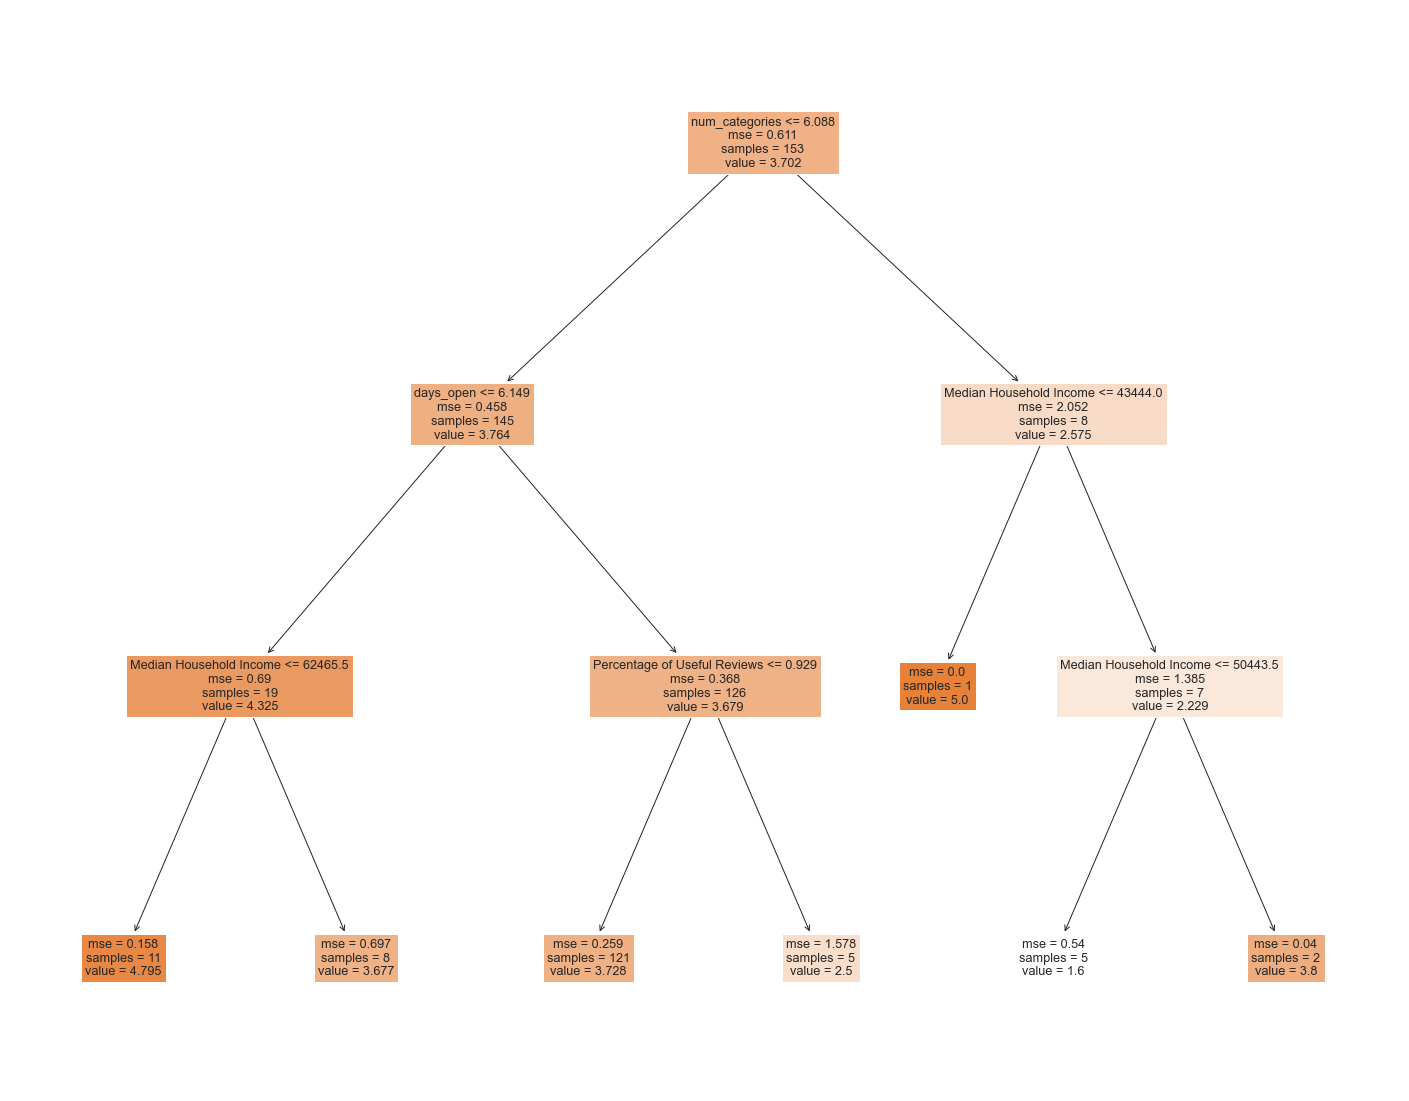

In [128]:
reviews_fig = plt.figure(figsize=(25,20))
reviews_fig = tree.plot_tree(reviews_tree, feature_names=X.columns, filled=True)

In [129]:
mccp = reviews_tree.cost_complexity_pruning_path(X, y)

In [130]:
mccp

{'ccp_alphas': array([0.        , 0.03786253, 0.04455882, 0.04613358, 0.0700204 ]),
 'impurities': array([0.32201016, 0.35987268, 0.44899033, 0.5412575 , 0.6112779 ])}

In [131]:
decision = reviews_tree.decision_path(X)
decision

<153x13 sparse matrix of type '<class 'numpy.int64'>'
	with 611 stored elements in Compressed Sparse Row format>

In [132]:
score = reviews_tree.score(X, y)
score

0.4732180574632131

# Conclusion

From the analysis of the data collected on businesses from Yelp's Open Source Dataset, we found that the frequency of a business's star ratings and the number of days of the week where it is open is very negatively skewed. Therefore, a mojority of the businesses have a very high rating or open for six to seven days of the week, however, there may be a small number of businesses that have low ratings or open for five days or less. We also found that the frequency of the number of additional positive attributes and the number of categories the business belongs to is very positively skewed. This indicates that a majority of businesses one have a few additional positive attributes or categories on their profile, and a very small amount of businesses may have a lot on their profile. 

Through the histograms, it seemed as though there was a relationship between the X variables and the outcome (Y) variables, however, due to the skew of the individual variables, we cannot conclude that there is a relationship between the X and Y variables. 

From the visualizations of the Y and X variables through plots and maps, we were able to find that businesses that are located near the center of the county tend to have higher ratings, as well as higher number of days open. 

For my next steps, I think that it would be interesting to try to extend my question and do some further analysis. Could the reason behind the negative skew in business star ratings be attributed to users having a tendency to write more positive reviews than negative ones? Is the positive skew in additional positive labels and categories on a business's profile on Yelp due to the belief that a business who have lower ratings may attract more customers through more exposure? I also think that next time, it would be good to analyze the data on user reviews and incorporate the results into my analysis as well. 